In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans as k_means_sklearn
import time

## K-means - My implementation

In [2]:
class k_means(object):
    def __init__(self, n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, verbose = False, random_state = None, copy_x = True, algorithm = 'auto', median_flag = False, vectorise = True):
        
        self.n_clusters = n_clusters #number of clusters to initialise
        self.init = init #'k-means++' selects initial clusters intelligently. 'random' chooses n_clusters rows at random
        self.n_init = n_init #Number of time the k-means algorithm will be run with different centroid seeds.
        self.max_iter = max_iter #max iterations for a single run
        self.tol = tol #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers
        #of two consecutive iterations to declare convergence.
        self.verbose = verbose #If verbose = 1, print loss over iterations
        self.random_state = random_state #Determines random number generation for centroid initialisation
        self.copy_x = copy_x #Will not modify the original data, if False, data is centered and then uncentered
        self.algorithm = algorithm #EM or elkan
        self.median_flag = median_flag
        self.vectorise = vectorise #To try and vectorise the loops
        
        if random_state is not None:
            np.random.RandomState(self.random_state)
        
        #initialised parameters
        #self.cluster_centers_ = None #coordinates of cluster centers.
        #self.labels_ = None #labels of each point
        #self.inertia_ = None #sum of squared distances of samples to their closest center, weighted by sample weights if required
        self.inertia_train_ = None #List of inertia over the optimal run
        self.n_iter_ = None #Number of iterations runs
    
    def label_data(self, X):
        N = X.shape[0]
        labels = []
        
        if self.vectorise:
            mse_mat = np.zeros((N, self.n_clusters))
            
            for k in range(self.n_clusters):
                mse_mat[:, k] = np.sum((self.cluster_centers_[k, :] - X)**2, axis = 1)
            
            labels = np.argmin(mse_mat, axis = 1)
            
        else:
            for i in range(N):
                mse = np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1)
                labels.append(np.argmin(mse))
        
        return np.array(labels)
    
    def compute_centroids(self, X):
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        
        #Already vectorised to some extent
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.median_flag:
                new_centers[k, :] = np.median(X[label_indices, :], axis = 0)
            else:
                new_centers[k, :] = np.mean(X[label_indices, :], axis = 0)
                
        tol = np.linalg.norm(self.cluster_centers_ - new_centers)
        
        self.cluster_centers_ = new_centers

        return tol
        
    def calculate_inertia(self, X):
        
        J = 0
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.vectorise:
                if self.median_flag:
                    J += np.sum(np.abs(self.cluster_centers_[k, :] - X[label_indices, :]))
                    
                else:
                    J +=np.sum((self.cluster_centers_[k, :] - X[label_indices, :])**2)
            
            else:
                for i in label_indices:

                    if self.median_flag:
                        J += np.sum(np.abs(self.cluster_centers_[k, :] - X[i, :]))
                    else:
                        J += np.sum((self.cluster_centers_[k, :] - X[i, :])**2)
        
        self.inertia_ = J
    
    def initialise_centroids(self, X):
        
        if self.init == 'k-means++':
            print("Initialisation not implemented.")
            raise SystemExit
        
        elif self.init == 'random':
            
            points = np.random.randint(0, X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[points, :]
        
        else:
            print("Illegal initialisation.")
            raise SystemExit
    
    def standardise(self, X):
        self._mu_ = np.mean(X, axis = 0)
        self._std_ = np.std(X, axis = 0)
        
        return (X - self._mu_) / self._std_
    
    def unstandardise(self, X):
        
        return (X * self._std_) + self._mu_
        
    def fit(self, X, sample_weights = None, calculate_scores = True):
        
        if self.verbose:
            print("Beginning K-means...")
        
        #Check to see if you must standardise
        if not self.copy_x:
            X = self.standardise(X)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            
            #initialise centroids
            self.initialise_centroids(X)
            
            #Calculate initial inertia
            self.labels_ = self.label_data(X)
            self.calculate_inertia(X)
            
            local_inertia_list = []
            
            tol = np.inf
            cnt = 0
            
            if self.verbose:
                print("\n Beginning outer iteration {}...".format(outer_iter))
            
            while cnt < self.max_iter and tol > self.tol:
                
                #E step
                self.labels_ = self.label_data(X)
                #print(self.labels_)
                
                #M step
                tol = self.compute_centroids(X)
                
                #Calculate loss
                self.calculate_inertia(X)
                
                #Finalise iteration
                local_inertia_list.append(self.inertia_)
                cnt += 1
                
                if self.verbose:
                    print("Outer iteration {}: inertia: {}".format(outer_iter, self.inertia_))
            
            iter_dict[str(outer_iter)] = {"centers":self.cluster_centers_,
                                          "labels":self.labels_,
                                          "loss_list":local_inertia_list,
                                          "n_iters":cnt}
            
            if optimal_inertia > self.inertia_:
                optimal_inertia = self.inertia_
                optimal_outer = outer_iter
                
        if self.verbose:
            print("\n Finished Training! Automatically selecting optimal centers...")
        
        #Load in optimal clusters
        self.cluster_centers_ = iter_dict[str(optimal_outer)]["centers"]
        
        #Label data
        self.labels_ = iter_dict[str(optimal_outer)]["labels"] #Will create a disjoint if it terminates early
        
        #Store loss list
        self.inertia_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        
        #Store the iteration dict
        self.iter_dict = iter_dict
        
        #Check to see if you must un-standardise
        if not self.copy_x:
            X = self.unstandardise(X)
            self.cluster_centers = self.unstandardise(self.cluster_centers)
        
        if calculate_scores:
            if self.verbose:
                print("Calculating the Silhouette score...")

            #Calculate the silhouette score
            self.silhouette_score = self.Silhouette(X, self.labels_)
        
        return self
        
    
    def predict(self, X, sample_weight = None):
        labels = self.label_data(X)
        
        return labels
    
    def fit_predict(self, X, sample_weight = None, calculate_scores = True):
        self.fit(X, sample_weight, calculate_scores)
        labels = self.predict(X)
        
        return labels
    
    def fit_transform(self, X, sample_weights = None, calculate_scores = True):
        self.fit(X, sample_weights, calculate_scores)
        X_new = self.transform(X)
        
        return X_new
    
    def score(self, X, sample_weight = None):
        
        N, _ = X.shape
            
        min_distance = np.zeros(N)
        
        if self.vectorise:
            
            d_mat = np.zeros((N, self.n_clusters))
            
            for k in self.n_clusters:
                d_mat[:, k] = np.sqrt(np.sum((self.cluster_centers_[[k], :] - X)**2, axis = 1))
            
            min_distance = np.min(d_mat, axis = 1)
        
        else:
            for i in range(N):

                d_clusters = np.sqrt(np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1))

                min_distance[i] = np.min(d_clusters)
        
        return min_distance
            
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

    def transform(self, X): #transform X to a cluster-distance space
        print("Transform is not implemented.")
        return None
    

## Random ball - class

In [3]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

## Covariance plotter

In [4]:
def plot_ellipse(mean, covariance, X2_critical = 5.991, pca_method = True):
    
    if covariance.shape[0] == 2:
        
        t = np.linspace(0, 2 * np.pi, 1000)

        eig_vals, eig_vect = np.linalg.eig(covariance)

        pos_max = np.argmax(eig_vals)
        pos_min = np.abs(1 - pos_max)
    
        
        a = np.sqrt(X2_critical * eig_vals[pos_max])
        b = np.sqrt(X2_critical * eig_vals[pos_min])
        
        z = np.array([a * np.cos(t), b * np.sin(t)]).T

        
        if not pca_method:
            #Method 1
            alpha = np.arctan(eig_vect[1, pos_max] / eig_vect[0, pos_max])# - np.pi/2
            
            R = np.array([[np.cos(alpha), -np.sin(alpha)],
                          [np.sin(alpha), np.cos(alpha)]])

            #x = R . z
            #x.T = z . R.T
            X = np.dot(z, R.T)
        else:
            #Method 2
            #Basically performing reverse of PCA, generate data in Z space, project back using eigenvectors
            ordered_eig_vect = eig_vect[:, [pos_max, pos_min]] #Rotate using Eigenvectors!
            
            #x = U * z
            #x.T = z . U.T
            X = np.dot(z, ordered_eig_vect.T)
        
        return mean + X

## GMM class

In [5]:
class gaussian_mixture_models(object):
    def __init__(self, n_components, covariance_type = 'full', tol = 0.001, reg_covar = 1e-12, max_iter = 100, n_init = 1, init_params = 'kmeans', use_sklearn = False, random_state = None, warm_start = False, verbose = False, verbose_interval = 10, vectorise = True):
        
        self.n_components = n_components
        self.covariance_type = covariance_type #full, tied, diag, spherical
        self.tol = tol #convergence threshold, stops when lower bound avg gain is below threshold
        self.reg_covar = reg_covar #Non-negative regularisation added to the diagonal of covariance. Ensures cov is positive
        self.max_iter = max_iter #Number of EM iterations
        self.n_init = n_init #Number of initialisations to perform
        self.init_params = init_params #'k-means' or 'random' - specifies how to initialise means and covariances
        self.use_sklearn = use_sklearn
        self.random_state = random_state #controls the random seed to initialise the parameters of the model
        self.warm_start = warm_start #if True, solution of last fitting is used to initialise the next run
        self.verbose = verbose #Controls what you print
        self.verbose_interval = verbose_interval #Intervals between prints
        self.vectorise = vectorise #Controls if you want to use loops or matrices to calculate x^T A x operations
        
        #Attributes
        #self.weights_ = None #Mixture weights #(n_components,)
        #self.means_ = None #Mixture means (n_components, n_features)
        #self.covariances = None #Mixture covariances
        # spherical: (n_components, )
        # diagonal: (n_components, n_features)
        # tied: (n_features, n_features)
        # full: (n_components, n_features, n_features)
        #self.converged_ = False #Flag to tell if the model converged
        #self.n_iter_ = None #Number of steps to finalise run
        #self.lower_bound_ = None #lower bound value of the log-likelihood (training data wrt model for best fit model)
        #self.n_features_in_ = None #number of features seen during fit
    
    def set_params(self, X):
        
        Ntotal, self.n_features_in_ = X.shape
        
        #Initialise weight (mixing coeffient) vector
        mix_init = np.zeros((self.n_components,))
        
        #Initialise mean matrix
        mu_init = np.zeros((self.n_components, self.n_features_in_))

        #Initialise covariance matrix
        if self.covariance_type == 'spherical':
            cov_init = np.zeros((self.n_components,))
        
        elif self.covariance_type == 'diagonal':
            cov_init = np.zeros((self.n_components, self.n_features_in_))
        
        elif self.covariance_type == 'tied':
            cov_init = np.zeros((self.n_features_in_, self.n_features_in_))
        
        elif self.covariance_type == 'full':
            cov_init = np.zeros((self.n_components, self.n_features_in_, self.n_features_in_))
        
        else:
            print("Incompatible covariance_type entered.")
            raise SystemExit
        
        if self.init_params == 'kmeans':
            
            if self.use_sklearn:
                self.k_means_local = k_means_sklearn(self.n_components, 
                                                     random_state = self.random_state, 
                                                     verbose = self.verbose)
                
                label = self.k_means_local.fit_predict(X)
                
            else:
                self.k_means_local = k_means(self.n_components, 
                                             'random', 
                                             random_state = self.random_state, 
                                             verbose = self.verbose,
                                             vectorise = True)
                print("\nRunning k-means to initialise model parameters...")
                                                                                       
                label = self.k_means_local.fit_predict(X, calculate_scores = False)
                
            print("\nFinished k-means")
            
            for i in range(self.n_components):
                label_indices = np.nonzero(label == i)[0]
                
                x_cluster = X[label_indices, :]
                N = len(label_indices)
                
                #Update mixing matrix
                mix_init[i] = len(label_indices) / Ntotal
                
                #Save mean
                mu_init[i, :] = np.mean(x_cluster, axis = 0)
                
                #Calculate standard covariance
                z = x_cluster - mu_init[i, :]
                covariance_cluster = 1/(N - 1) * np.dot(z.T, z)
                
                #Add in regularisation term
                covariance_cluster += np.eye(self.n_features_in_) * self.reg_covar
                
                if self.covariance_type == 'spherical':
                    cov_init[i] = np.mean(np.diag(covariance_cluster))

                elif self.covariance_type == 'diagonal':
                    cov_init[i, :] = np.diag(covariance_cluster)
                
                elif self.covariance_type == 'tied':
                    cov_init += covariance_cluster

                elif self.covariance_type == 'full':
                    cov_init[i, :, :] = covariance_cluster
            
            if self.covariance_type == 'tied':
                cov_init /= self.n_components #Average covariance matrix
            
        
        elif self.init_params == 'random':
            print("'random' init_params initialisation not implemented.")
            raise SystemExit
        
        else:
            print("Incompatible init_params entered.")
            raise SystemExit
        
        #Save matrices
        self.weights_ = mix_init
        self.means_ = mu_init
        self.covariances_ = cov_init
    
    def get_params(self):
        
        #returns covariances as a k x D x D matrix, regardless of type
        
        covariance = np.zeros((self.n_components, self.n_features_in_, self.n_features_in_))
        
        for k in range(self.n_components):
            if self.covariance_type == 'spherical':
                    covariance[k, :, :] = np.diag(self.covariances_[k] * np.ones(self.n_features_in_))

            elif self.covariance_type == 'diagonal':
                covariance[k, :, :] = np.diag(self.covariances_[k, :])

            elif self.covariance_type == 'tied':
                covariance[k, :, :] = self.covariances_

            elif self.covariance_type == 'full':
                covariance[k, :, :] = self.covariances_[k, :, :]
        
        return self.weights_, self.means_, covariance
    
    def evaluate_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #Sorry prof. Kok
        
        if self.vectorise:
            D = x.shape[1]
            z - x - mu.reshape(1, -1) #reshape mu
            
            second_part = np.exp((-1 / 2) * np.sum(np.dot(z, precision) * z, axis = 1))
        
        else: #vector inputs for mu and x_vec
            D = x.shape[0]
            z = x - mu
        
            second_part = np.exp((-1 / 2) * np.dot(z.T, np.linalg.solve(covariance, z)))
        
        
        
        first_part = 1 / ((2 * np.pi)**(D / 2))  * 1 / (np.linalg.det(covariance)**(1/2))
        
        return first_part * second_part
    
    def evaluate_log_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #Sorry prof. Kok
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1)
            
            third_part = -1/2 * np.sum(np.dot(z, precision) * z, axis = 1)
        
        else:     
            D = x.shape[0]
            z = x - mu
            third_part = -1/2 * np.dot(z.T, np.linalg.solve(covariance, z))

        first_part = -D/2 * np.log(2 * np.pi)
        second_part = -1/2 * np.log(np.linalg.det(covariance))
        
        return first_part + second_part + third_part
    
    def data_likelihood(self, x): #p(x)
        
        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mix, mu, cov = self.get_params()
        
        if self.vectorise:
            N = x.shape[0]
        
        else:
            N = 1
        
        log_likelihoods = np.zeros((N, self.n_components))
        
        for k in range(self.n_components):
            
            mean_vec = mu[[k], :].T #N x 1 vector
            cov_mat = cov[k, :, :] #N x N matrix

            if self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(x, mean_vec, cov_mat) + np.log(mix[k])
                
            else:
                log_likelihoods[0, k] = self.evaluate_log_gauss(x, mean_vec, cov_mat) + np.log(mix[k])

        #Apply log-sum-exp trick
        A = np.max(log_likelihoods, axis = 1, keepdims=True)
    
        log_likelihood_sum = A + np.log(np.sum(np.exp(log_likelihoods - A), axis = 1, keepdims = True))
        
        p_x = np.exp(log_likelihood_sum)
        
        return p_x, log_likelihoods, log_likelihood_sum
    
    def posterior_likelihood(self, x): #Calculates the responsibilities 
        
        _, log_likelihoods, log_likelihood_sum = self.data_likelihood(x)
        
        responsibility = np.exp(log_likelihoods - log_likelihood_sum)
        
        return responsibility
    
    def log_likelihood(self, X, sum_flag = True): #We apply the log-sum-exp trick again here, to avoid numerical underflow
        
        N = X.shape[0]
        
        mix, mu, cov = self.get_params()
        LL = np.zeros((N, 1))
        
        if self.vectorise:
            LL = self.data_likelihood(X)[2]
        
        else:
            for i in range(N):

                x_vec = X[[i], :].T #N x 1 vector

                #Add log-likelihood
                LL[i, 0] = self.data_likelihood(x_vec)[2]
        
        if sum_flag:
            return np.sum(LL)
        
        else:
            return LL
    
    def Nk(self, X):
        N = X.shape[0]
        
        resp_mat = np.zeros((N, self.n_components))
        
        if self.vectorise:
            resp_mat[:, :] = self.posterior_likelihood(X)
        
        else:
            for i in range(N):
                resp_mat[i, :] = self.posterior_likelihood(X[[i], :].T)
        
        N_vec = np.sum(resp_mat, axis = 0)
        
        return N_vec, resp_mat
    
    def update_mu(self, X, resp_mat, N_vec):
        
        mu_new = np.zeros_like(self.means_)
        
        for i in range(self.n_components):
            mu_new[i, :] = np.sum(resp_mat[:, [i]] * X, axis = 0) / N_vec[i]
        
        self.means_ = mu_new
    
    def update_covar(self, X, resp_mat, N_vec):
        
        N, D = X.shape
        cov_mat = np.zeros_like(self.covariances_)
        
        if self.covariance_type == 'spherical':
            
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros((1, 1))
                
                if self.vectorise:
                    z = X - self.means_[[k], :]
                    
                    placeholder_cov[0, 0] = np.sum(resp_mat[:, [k]] * z**2)
                
                else:
                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * np.dot(z.T, z)
                
                #Normalise by D * Nk
                placeholder_cov /= (D * N_vec[k])

                cov_mat[k] = placeholder_cov[0, 0] + self.reg_covar #Add in regularisation term

        elif self.covariance_type == 'diagonal':
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros((self.n_features_in_, 1))
                
                if self.vectorise:
                    z = X - self.means_[[k], :]

                    placeholder_cov[:, 0] = np.sum(resp_mat[:, [k]] * (z**2), axis = 0)
                        
                else:
                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * (z**2)
                
                #Normalise by Nk
                placeholder_cov /= N_vec[k]

                cov_mat[k, :] = placeholder_cov[:, 0] + self.reg_covar #Add in regularisation term

        elif self.covariance_type == 'tied':
            
            placeholder_cov = np.zeros_like(cov_mat)
            
            for k in range(self.n_components):

                if self.vectorise:
                    z = X - self.means_[[k], :]

                    einsum = resp_mat[:, k].reshape(-1, 1, 1) * np.einsum('ij, ik ->ijk', z, z)
                    placeholder_cov += np.sum(einsum, axis = 0)

                else:

                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += np.dot(z, z.T)
                
            #Normalise by N
            placeholder_cov /= (N)

            cov_mat = placeholder_cov + np.eye(self.n_features_in_) * self.reg_covar #Add in regularisation term

        elif self.covariance_type == 'full':
            
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros_like(cov_mat[k, :, :])
                
                if self.vectorise:
                    z = X - self.means_[[k], :]

                    einsum = resp_mat[:, k].reshape(-1, 1, 1) * np.einsum('ij, ik ->ijk', z, z)
                    placeholder_cov += np.sum(einsum, axis = 0)

                else:

                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * np.dot(z, z.T)
                
                #Normalise by Nk
                placeholder_cov /= N_vec[k]
                
                cov_mat[k, :, :] = placeholder_cov + np.eye(self.n_features_in_) * self.reg_covar #Add in regularisation term
        
        #Update covariance variable
        self.covariances_ = cov_mat
    
    def update_mixture(self, X, N_vec):
        N = X.shape[0]
        
        mix_new = N_vec / N
        
        self.weights_ = mix_new
    
    def fit(self, X, calculate_scores = True):
        
        if self.verbose:
            t0 = time.time()
            print("\nBeginning GMM training...")
        
        if not hasattr(self, "means_") or not hasattr(self, "covariances_") or not hasattr(self, "weights_"):
            self.set_params(X)
            
        
        if self.verbose:
            print("Running GMM...")
        
        tol = np.inf
        cnt = 0
        loss_train = [self.log_likelihood(X)]

        while cnt < self.max_iter and tol > self.tol:
            #Determine responsibilities for each class
            N_vec, resp_mat = self.Nk(X)

            #Update means
            self.update_mu(X, resp_mat, N_vec)

            #Update covariance
            self.update_covar(X, resp_mat, N_vec)

            #Update mixture coefficients
            self.update_mixture(X, N_vec)

            #Calculate log-likelihood
            loss = self.log_likelihood(X, sum_flag = True)
            
            tol = np.abs(loss_train[-1] - loss)
            
            if self.verbose:
                print("\nLoss at epoch {}: {}\nTolerance: {}".format(cnt, loss, tol))

            #Update other variables
            cnt += 1
            loss_train.append(loss)
        
        if self.verbose:
            t1 = time.time()
            print("\nFinished GMM training!\nTime to train: {:.4f} seconds".format(t1 - t0))
            
        #Store attributes
        self.n_iter_ = cnt
        
        if cnt <= self.max_iter or tol <= self.tol:
            self.converged = True
        
        else:
            self.converged = False
        
        self.lower_bound_ = loss_train[-1] / x.shape[0]
        self.loss_train_ = np.array(loss_train)
        self.labels_ = self.predict(X)
        
        if calculate_scores:
            if self.verbose:
                print("Calculating Silhouette score...")

            self.silhouette_score = self.Silhouette(X, self.labels_)


            if self.verbose:
                print("Calculating AIC...")

            self.aic_score = self.aic(X)

            if self.verbose:
                print("Calculating BIC...")

            self.bic_score = self.bic(X)
        
        return self
    
    def predict(self, X):
        
        resp_mat = self.predict_proba(X)
        
        labels = np.argmax(resp_mat, axis = 1)
        
        return labels
    
    def fit_predict(self, X):
        
        self.fit(X)
        labels = self.predict(X)
        
        return labels
    
    def estimate_centroids(self):
        pass #No clue what this does xD
    
    def sample(self, n_samples = 1):
        pass
    
    def predict_proba(self, X):
        
        _, responsibilities = self.Nk(X)
        
        return responsibilities
    
    def score(self, X):
        return self.log_likelihood(X, sum_flag = True)
    
    def score_samples(self, X):
        return self.log_likelihood(X, sum_flag = False)
    
    def n_parameters(self):
        return np.sum(self.means_.shape) + np.sum(self.covariances_.shape) + np.sum(self.weights_.shape)
    
    def aic(self, X, unbiased = True, adjust = True):
        
        N = X.shape[0]
        n_parameters = self.n_parameters()
        
        term1 = self.score(X)
        
        if unbiased:
            term2 = n_parameters + (n_parameters * (n_parameters + 1))/(N - n_parameters - 1)
        
        else:
            term2 = n_parameters
        
        aic_value = term1 - term2
        
        if adjust:
            aic_value *= -2
            
        return aic_value
    
    def bic(self, X, adjust = True):
        
        N = X.shape[0]
        
        bic_value = self.score(X) - 1/2 * self.n_parameters() * np.log(N)
        
        if adjust:
            bic_value *= -2
        
        return bic_value
    
    def KL_divergence(self):
        pass
        #Only useful if you decide to split the dataset in half and test divergence between them
    
    def JS_divergence(self):
        pass
        #Only useful if you decide to split the dataset in half and test divergence between them
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

## Setup dataset

[[ 1.  -0.8]
 [-0.8  1. ]]


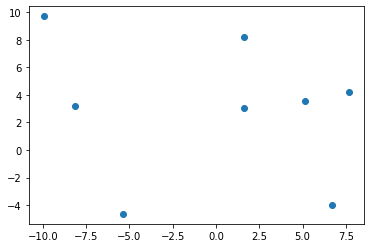


Covariance is positive definite.
(5000, 2)


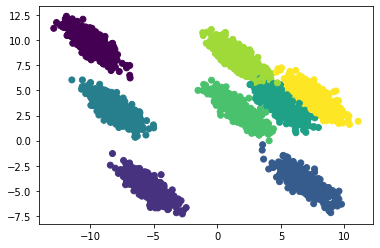

In [6]:
sample_blobs = sample_random_balls(8, var_x = 1, var_y = 1, var_xy = -0.8)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(5000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

## k-means run - My implementation

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 188038.1948020768
Outer iteration 0: inertia: 171533.2914934256
Outer iteration 0: inertia: 157969.39734724566
Outer iteration 0: inertia: 147040.71350219453
Outer iteration 0: inertia: 146183.97165666707
Outer iteration 0: inertia: 146181.11969701143
Outer iteration 0: inertia: 146181.11969701143

 Beginning outer iteration 1...
Outer iteration 1: inertia: 148628.19662775623
Outer iteration 1: inertia: 146181.11969701143
Outer iteration 1: inertia: 146181.11969701143

 Beginning outer iteration 2...
Outer iteration 2: inertia: 159207.83220250945
Outer iteration 2: inertia: 147324.3616117259
Outer iteration 2: inertia: 146181.11969701143
Outer iteration 2: inertia: 146181.11969701143

 Beginning outer iteration 3...
Outer iteration 3: inertia: 222431.5956349523
Outer iteration 3: inertia: 172443.97483993697
Outer iteration 3: inertia: 166645.5217199144
Outer iteration 3: inertia: 161781.12636510373
Outer 

Outer iteration 32: inertia: 241711.5508717511

 Beginning outer iteration 33...
Outer iteration 33: inertia: 232167.26590956724
Outer iteration 33: inertia: 146181.11969701143
Outer iteration 33: inertia: 146181.11969701143

 Beginning outer iteration 34...
Outer iteration 34: inertia: 206593.1824115985
Outer iteration 34: inertia: 177542.5646852506
Outer iteration 34: inertia: 164354.491546848
Outer iteration 34: inertia: 150560.40173177666
Outer iteration 34: inertia: 146210.34123125533
Outer iteration 34: inertia: 146181.11969701143
Outer iteration 34: inertia: 146181.11969701143

 Beginning outer iteration 35...
Outer iteration 35: inertia: 170497.47752817188
Outer iteration 35: inertia: 165978.53037032517
Outer iteration 35: inertia: 160126.10843541689
Outer iteration 35: inertia: 148550.1135504545
Outer iteration 35: inertia: 146181.11969701143
Outer iteration 35: inertia: 146181.11969701143

 Beginning outer iteration 36...
Outer iteration 36: inertia: 230060.37903680306
Outer 

Outer iteration 13: inertia: 92017.24271159939
Outer iteration 13: inertia: 92017.24271159939

 Beginning outer iteration 14...
Outer iteration 14: inertia: 219693.3892854553
Outer iteration 14: inertia: 112930.21071730714
Outer iteration 14: inertia: 108331.24025113997
Outer iteration 14: inertia: 105294.55257306306
Outer iteration 14: inertia: 101630.60974803503
Outer iteration 14: inertia: 97504.78992350963
Outer iteration 14: inertia: 95860.57836890993
Outer iteration 14: inertia: 95446.79227033225
Outer iteration 14: inertia: 94999.22654814759
Outer iteration 14: inertia: 94405.81710008385
Outer iteration 14: inertia: 93689.44783361007
Outer iteration 14: inertia: 92933.24374589794
Outer iteration 14: inertia: 92335.51167042593
Outer iteration 14: inertia: 92047.9231210566
Outer iteration 14: inertia: 92019.51897037645
Outer iteration 14: inertia: 92017.24271159939
Outer iteration 14: inertia: 92017.24271159939

 Beginning outer iteration 15...
Outer iteration 15: inertia: 158033.

Outer iteration 27: inertia: 103445.30426465295
Outer iteration 27: inertia: 94601.1141346085
Outer iteration 27: inertia: 94542.09176452368
Outer iteration 27: inertia: 94542.09176452368

 Beginning outer iteration 28...
Outer iteration 28: inertia: 142590.96675221232
Outer iteration 28: inertia: 122728.51353437864
Outer iteration 28: inertia: 121175.37757150971
Outer iteration 28: inertia: 120855.76510492279
Outer iteration 28: inertia: 120749.35159646609
Outer iteration 28: inertia: 120707.00593718434
Outer iteration 28: inertia: 120695.39290943157
Outer iteration 28: inertia: 120690.3541188497
Outer iteration 28: inertia: 120688.44244545867
Outer iteration 28: inertia: 120687.4678432361
Outer iteration 28: inertia: 120687.20086344906
Outer iteration 28: inertia: 120686.85391451254
Outer iteration 28: inertia: 120685.57963748372
Outer iteration 28: inertia: 120685.44399603845
Outer iteration 28: inertia: 120685.44399603845

 Beginning outer iteration 29...
Outer iteration 29: inerti

Outer iteration 42: inertia: 112949.24576529916
Outer iteration 42: inertia: 106163.97142692635
Outer iteration 42: inertia: 105446.97624327242
Outer iteration 42: inertia: 105427.8947209316
Outer iteration 42: inertia: 105418.07061517543
Outer iteration 42: inertia: 105402.24545813256
Outer iteration 42: inertia: 105393.04858906614
Outer iteration 42: inertia: 105382.70847090335
Outer iteration 42: inertia: 105376.14092365536
Outer iteration 42: inertia: 105371.12537123555
Outer iteration 42: inertia: 105368.78481143097
Outer iteration 42: inertia: 105367.50862505392
Outer iteration 42: inertia: 105367.50862505392

 Beginning outer iteration 43...
Outer iteration 43: inertia: 194784.15819538257
Outer iteration 43: inertia: 137638.97845006868
Outer iteration 43: inertia: 109452.82284116892
Outer iteration 43: inertia: 94718.63901708773
Outer iteration 43: inertia: 94542.09176452368
Outer iteration 43: inertia: 94542.09176452368

 Beginning outer iteration 44...
Outer iteration 44: iner


 Beginning outer iteration 10...
Outer iteration 10: inertia: 63467.95837923912
Outer iteration 10: inertia: 56540.752402367536
Outer iteration 10: inertia: 55721.753988382414
Outer iteration 10: inertia: 55432.69020714891
Outer iteration 10: inertia: 55045.00648056414
Outer iteration 10: inertia: 54632.24560895991
Outer iteration 10: inertia: 54095.06767104493
Outer iteration 10: inertia: 53434.12343604823
Outer iteration 10: inertia: 52685.66208783622
Outer iteration 10: inertia: 52029.83236745944
Outer iteration 10: inertia: 51580.051439095514
Outer iteration 10: inertia: 51467.92500576259
Outer iteration 10: inertia: 51457.668324868355
Outer iteration 10: inertia: 51457.668324868355

 Beginning outer iteration 11...
Outer iteration 11: inertia: 171249.4971557081
Outer iteration 11: inertia: 128902.8791257398
Outer iteration 11: inertia: 99586.93498907748
Outer iteration 11: inertia: 89729.83581231131
Outer iteration 11: inertia: 88681.73674909407
Outer iteration 11: inertia: 88498

Outer iteration 30: inertia: 56674.95178958748
Outer iteration 30: inertia: 56372.45835552136
Outer iteration 30: inertia: 55899.246203957366
Outer iteration 30: inertia: 55289.86555849479
Outer iteration 30: inertia: 54336.85063403953
Outer iteration 30: inertia: 53064.92831841185
Outer iteration 30: inertia: 51865.377368937334
Outer iteration 30: inertia: 51485.59842904842
Outer iteration 30: inertia: 51459.59103818692
Outer iteration 30: inertia: 51457.668324868355
Outer iteration 30: inertia: 51457.668324868355

 Beginning outer iteration 31...
Outer iteration 31: inertia: 70502.52349177081
Outer iteration 31: inertia: 56667.711987022485
Outer iteration 31: inertia: 55823.63379966782
Outer iteration 31: inertia: 55550.22686543107
Outer iteration 31: inertia: 55204.63187704058
Outer iteration 31: inertia: 54806.784470816296
Outer iteration 31: inertia: 54343.2330495777
Outer iteration 31: inertia: 53732.05675483313
Outer iteration 31: inertia: 53004.08653271198
Outer iteration 31: i

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 95789.29898701029
Outer iteration 0: inertia: 39390.24242858564
Outer iteration 0: inertia: 38333.847700335005
Outer iteration 0: inertia: 37891.930840389075
Outer iteration 0: inertia: 37413.53622423773
Outer iteration 0: inertia: 36796.255284508225
Outer iteration 0: inertia: 36063.90809441361
Outer iteration 0: inertia: 35304.80468473476
Outer iteration 0: inertia: 34776.52033741813
Outer iteration 0: inertia: 34541.12029062457
Outer iteration 0: inertia: 34512.59071310593
Outer iteration 0: inertia: 34510.1853049208
Outer iteration 0: inertia: 34510.1853049208

 Beginning outer iteration 1...
Outer iteration 1: inertia: 62689.571897205664
Outer iteration 1: inertia: 39488.30848027302
Outer iteration 1: inertia: 36561.49743071891
Outer iteration 1: inertia: 36546.92992586574
Outer iteration 1: inertia: 36546.92992586574

 Beginning outer iteration 2...
Outer iteration 2: inertia: 44282.61885992384
Oute

Outer iteration 17: inertia: 51326.99193995193
Outer iteration 17: inertia: 47696.337138770425
Outer iteration 17: inertia: 39098.16434141903
Outer iteration 17: inertia: 35244.576266518285
Outer iteration 17: inertia: 34671.48422759738
Outer iteration 17: inertia: 34554.49832506568
Outer iteration 17: inertia: 34517.396721253695
Outer iteration 17: inertia: 34511.80187396548
Outer iteration 17: inertia: 34509.71966286845
Outer iteration 17: inertia: 34509.57492650923
Outer iteration 17: inertia: 34509.57492650923

 Beginning outer iteration 18...
Outer iteration 18: inertia: 53123.93437557667
Outer iteration 18: inertia: 42068.62015916621
Outer iteration 18: inertia: 41221.12155272361
Outer iteration 18: inertia: 40733.34396681304
Outer iteration 18: inertia: 39927.15958888457
Outer iteration 18: inertia: 38736.53320739527
Outer iteration 18: inertia: 37343.91687001036
Outer iteration 18: inertia: 36623.404862546304
Outer iteration 18: inertia: 36548.852639184304
Outer iteration 18: i

Outer iteration 33: inertia: 34861.341601246815
Outer iteration 33: inertia: 34693.88129806563
Outer iteration 33: inertia: 34593.24478464422
Outer iteration 33: inertia: 34548.48278000606
Outer iteration 33: inertia: 34530.07630185697
Outer iteration 33: inertia: 34522.71002286031
Outer iteration 33: inertia: 34518.486880939075
Outer iteration 33: inertia: 34514.83546553744
Outer iteration 33: inertia: 34512.932374842814
Outer iteration 33: inertia: 34510.29141183573
Outer iteration 33: inertia: 34510.27709280669
Outer iteration 33: inertia: 34510.1853049208
Outer iteration 33: inertia: 34510.1853049208

 Beginning outer iteration 34...
Outer iteration 34: inertia: 103699.27517827737
Outer iteration 34: inertia: 44524.74063880519
Outer iteration 34: inertia: 36653.505068337065
Outer iteration 34: inertia: 35298.05959994336
Outer iteration 34: inertia: 34748.93128889621
Outer iteration 34: inertia: 34547.01102735571
Outer iteration 34: inertia: 34522.29784066688
Outer iteration 34: ine

Outer iteration 49: inertia: 54482.03435786796
Outer iteration 49: inertia: 54077.59224314885
Outer iteration 49: inertia: 53602.33716717844
Outer iteration 49: inertia: 52938.392884506095
Outer iteration 49: inertia: 52154.010042834685
Outer iteration 49: inertia: 51447.214086327775
Outer iteration 49: inertia: 50853.440173468
Outer iteration 49: inertia: 50374.727378349424
Outer iteration 49: inertia: 47898.87137652213
Outer iteration 49: inertia: 38913.07353136728
Outer iteration 49: inertia: 35221.6950163496
Outer iteration 49: inertia: 34671.48422759738
Outer iteration 49: inertia: 34554.49832506568
Outer iteration 49: inertia: 34517.396721253695
Outer iteration 49: inertia: 34511.80187396548
Outer iteration 49: inertia: 34509.71966286845
Outer iteration 49: inertia: 34509.57492650924
Outer iteration 49: inertia: 34509.57492650924

 Finished Training! Automatically selecting optimal centers...
Calculating the Silhouette score...
Beginning K-means...

 Beginning outer iteration 0..

Outer iteration 12: inertia: 26365.63059246131
Outer iteration 12: inertia: 26365.49397158865
Outer iteration 12: inertia: 26365.4691794565
Outer iteration 12: inertia: 26365.4691794565

 Beginning outer iteration 13...
Outer iteration 13: inertia: 20806.202194691352
Outer iteration 13: inertia: 19895.341598161624
Outer iteration 13: inertia: 19745.416664097793
Outer iteration 13: inertia: 19671.097391974286
Outer iteration 13: inertia: 19630.860336723952
Outer iteration 13: inertia: 19615.726688943785
Outer iteration 13: inertia: 19610.603037672296
Outer iteration 13: inertia: 19606.751487567366
Outer iteration 13: inertia: 19603.623914874905
Outer iteration 13: inertia: 19601.074164789672
Outer iteration 13: inertia: 19599.55301283311
Outer iteration 13: inertia: 19599.538693804065
Outer iteration 13: inertia: 19599.44690591818
Outer iteration 13: inertia: 19599.44690591818

 Beginning outer iteration 14...
Outer iteration 14: inertia: 82336.73182607348
Outer iteration 14: inertia: 7

Outer iteration 26: inertia: 26365.82087850198
Outer iteration 26: inertia: 26365.71381021235
Outer iteration 26: inertia: 26365.630592461308
Outer iteration 26: inertia: 26365.49397158865
Outer iteration 26: inertia: 26365.4691794565
Outer iteration 26: inertia: 26365.4691794565

 Beginning outer iteration 27...
Outer iteration 27: inertia: 55770.52232112893
Outer iteration 27: inertia: 39193.05172981012
Outer iteration 27: inertia: 38174.693390344844
Outer iteration 27: inertia: 37907.09619642354
Outer iteration 27: inertia: 37568.89122048451
Outer iteration 27: inertia: 37170.9665886775
Outer iteration 27: inertia: 36699.151754109116
Outer iteration 27: inertia: 36038.32925776797
Outer iteration 27: inertia: 35260.91356537103
Outer iteration 27: inertia: 34569.13339406056
Outer iteration 27: inertia: 34040.758816413676
Outer iteration 27: inertia: 33849.29003149226
Outer iteration 27: inertia: 33829.70049607492
Outer iteration 27: inertia: 33828.74409208296
Outer iteration 27: inert

C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Outer iteration 35: inertia: 26740.9711842122
Outer iteration 35: inertia: 26393.283009972547
Outer iteration 35: inertia: 26367.201884559945
Outer iteration 35: inertia: 26365.4691794565
Outer iteration 35: inertia: 26365.4691794565

 Beginning outer iteration 36...
Outer iteration 36: inertia: 62194.79055329398
Outer iteration 36: inertia: 52641.13771293672
Outer iteration 36: inertia: 42617.51956786012
Outer iteration 36: inertia: 33624.80316902497
Outer iteration 36: inertia: 30854.56465380169
Outer iteration 36: inertia: 26749.65773852516
Outer iteration 36: inertia: 22251.27239393325
Outer iteration 36: inertia: 21152.093376725184
Outer iteration 36: inertia: 20918.105880791714
Outer iteration 36: inertia: 20679.619913187664
Outer iteration 36: inertia: 20404.865471047684
Outer iteration 36: inertia: 20138.34149204295
Outer iteration 36: inertia: 19926.22673020277
Outer iteration 36: inertia: 19762.672764353352
Outer iteration 36: inertia: 19676.145749160165
Outer iteration 36: i

Outer iteration 49: inertia: 26369.526697482477
Outer iteration 49: inertia: 26366.86760047332
Outer iteration 49: inertia: 26365.927574053345
Outer iteration 49: inertia: 26365.547907254047
Outer iteration 49: inertia: 26365.46346034872
Outer iteration 49: inertia: 26365.46346034872

 Finished Training! Automatically selecting optimal centers...
Calculating the Silhouette score...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 64664.52181460173
Outer iteration 0: inertia: 29867.262916053387
Outer iteration 0: inertia: 19889.493440366903
Outer iteration 0: inertia: 19032.958507623604
Outer iteration 0: inertia: 19027.20659050404
Outer iteration 0: inertia: 19025.543182455247
Outer iteration 0: inertia: 19025.36689271642
Outer iteration 0: inertia: 19025.36689271642

 Beginning outer iteration 1...
Outer iteration 1: inertia: 37794.69095608563
Outer iteration 1: inertia: 28819.47873061552
Outer iteration 1: inertia: 28439.577142364913
Outer iteration 1

Outer iteration 13: inertia: 25701.043061765602
Outer iteration 13: inertia: 25700.799906943834
Outer iteration 13: inertia: 25700.64254267808
Outer iteration 13: inertia: 25700.565946515446
Outer iteration 13: inertia: 25700.510964320016
Outer iteration 13: inertia: 25700.356594075107
Outer iteration 13: inertia: 25700.119737462166
Outer iteration 13: inertia: 25699.809525754303
Outer iteration 13: inertia: 25699.373222287824
Outer iteration 13: inertia: 25699.073698786455
Outer iteration 13: inertia: 25698.73957590061
Outer iteration 13: inertia: 25698.450311462737
Outer iteration 13: inertia: 25698.189917463027
Outer iteration 13: inertia: 25697.89523653433
Outer iteration 13: inertia: 25697.836225675117
Outer iteration 13: inertia: 25697.836225675117

 Beginning outer iteration 14...
Outer iteration 14: inertia: 26442.260143498963
Outer iteration 14: inertia: 21136.608387968125
Outer iteration 14: inertia: 20299.20716941664
Outer iteration 14: inertia: 20066.891777906352
Outer iter

Outer iteration 23: inertia: 24289.424939994627

 Beginning outer iteration 24...
Outer iteration 24: inertia: 78506.29231166758
Outer iteration 24: inertia: 70826.52952013632
Outer iteration 24: inertia: 50188.68163517923
Outer iteration 24: inertia: 46474.919043411835
Outer iteration 24: inertia: 44403.99472391629
Outer iteration 24: inertia: 42870.915234443346
Outer iteration 24: inertia: 42151.873400117
Outer iteration 24: inertia: 41723.65485265964
Outer iteration 24: inertia: 41406.97119050828
Outer iteration 24: inertia: 41099.89435833046
Outer iteration 24: inertia: 40863.33391170927
Outer iteration 24: inertia: 40634.95425271846
Outer iteration 24: inertia: 40371.329626860155
Outer iteration 24: inertia: 39969.84401117901
Outer iteration 24: inertia: 39485.51277687225
Outer iteration 24: inertia: 38690.81615064305
Outer iteration 24: inertia: 37500.189769153745
Outer iteration 24: inertia: 36107.57343176884
Outer iteration 24: inertia: 35387.06142430478
Outer iteration 24: ine


 Beginning outer iteration 35...
Outer iteration 35: inertia: 30260.757152866183
Outer iteration 35: inertia: 29125.859083961477
Outer iteration 35: inertia: 28681.065946512932
Outer iteration 35: inertia: 28420.901995539774
Outer iteration 35: inertia: 28355.705963627417
Outer iteration 35: inertia: 28326.70248163298
Outer iteration 35: inertia: 28270.140149991006
Outer iteration 35: inertia: 27831.666613777845
Outer iteration 35: inertia: 22393.396010815457
Outer iteration 35: inertia: 19116.632743744405
Outer iteration 35: inertia: 19027.818586960897
Outer iteration 35: inertia: 19025.350042063834
Outer iteration 35: inertia: 19025.350042063834

 Beginning outer iteration 36...
Outer iteration 36: inertia: 32794.630122488394
Outer iteration 36: inertia: 19965.088932395895
Outer iteration 36: inertia: 18952.225526424507
Outer iteration 36: inertia: 18933.32494422892
Outer iteration 36: inertia: 18929.98217584446
Outer iteration 36: inertia: 18928.367749149736
Outer iteration 36: ine

Outer iteration 47: inertia: 18919.096765514954

 Beginning outer iteration 48...
Outer iteration 48: inertia: 82824.19568731828
Outer iteration 48: inertia: 67542.1804607229
Outer iteration 48: inertia: 57554.101220585304
Outer iteration 48: inertia: 42646.23036258195
Outer iteration 48: inertia: 42090.853206393665
Outer iteration 48: inertia: 41765.5494032491
Outer iteration 48: inertia: 41465.75694857529
Outer iteration 48: inertia: 41235.436046424824
Outer iteration 48: inertia: 41009.45221835507
Outer iteration 48: inertia: 40745.83406511333
Outer iteration 48: inertia: 40344.387336571024
Outer iteration 48: inertia: 39860.115348398576
Outer iteration 48: inertia: 39065.41872216937
Outer iteration 48: inertia: 37874.79234068007
Outer iteration 48: inertia: 36482.17600329517
Outer iteration 48: inertia: 35761.66399583111
Outer iteration 48: inertia: 35687.111772469114
Outer iteration 48: inertia: 35685.18905915055
Outer iteration 48: inertia: 35685.18905915055

 Beginning outer ite

Outer iteration 9: inertia: 10791.782828442418
Outer iteration 9: inertia: 10791.782828442418

 Beginning outer iteration 10...
Outer iteration 10: inertia: 38994.867789325326
Outer iteration 10: inertia: 15862.028573048456
Outer iteration 10: inertia: 10640.215861573186
Outer iteration 10: inertia: 10356.535464400447
Outer iteration 10: inertia: 10183.255761629714
Outer iteration 10: inertia: 9943.003481125455
Outer iteration 10: inertia: 9710.160916120358
Outer iteration 10: inertia: 9545.964197990897
Outer iteration 10: inertia: 9444.199709014003
Outer iteration 10: inertia: 9399.070658415405
Outer iteration 10: inertia: 9385.573528712077
Outer iteration 10: inertia: 9381.87378813215
Outer iteration 10: inertia: 9381.14339203304
Outer iteration 10: inertia: 9380.883293201223
Outer iteration 10: inertia: 9380.258170668023
Outer iteration 10: inertia: 9380.187234918065
Outer iteration 10: inertia: 9380.117193955659
Outer iteration 10: inertia: 9379.989106103993
Outer iteration 10: ine

Outer iteration 20: inertia: 23624.15688250724
Outer iteration 20: inertia: 23623.752521785773
Outer iteration 20: inertia: 23623.470060842148
Outer iteration 20: inertia: 23623.12179721961
Outer iteration 20: inertia: 23622.90617941105
Outer iteration 20: inertia: 23622.64578541134
Outer iteration 20: inertia: 23622.351104482645
Outer iteration 20: inertia: 23622.292093623433
Outer iteration 20: inertia: 23622.292093623433

 Beginning outer iteration 21...
Outer iteration 21: inertia: 58156.44040062038
Outer iteration 21: inertia: 50729.73713081338
Outer iteration 21: inertia: 48744.18007768695
Outer iteration 21: inertia: 44000.963242723126
Outer iteration 21: inertia: 32315.263735179604
Outer iteration 21: inertia: 28096.93734898701
Outer iteration 21: inertia: 27719.20313099547
Outer iteration 21: inertia: 27437.763274315275
Outer iteration 21: inertia: 27037.93259965629
Outer iteration 21: inertia: 26566.157347823508
Outer iteration 21: inertia: 25951.05667496357
Outer iteration 2

Outer iteration 29: inertia: 25064.869156573466
Outer iteration 29: inertia: 23855.693592302414
Outer iteration 29: inertia: 23609.452914382982
Outer iteration 29: inertia: 23548.388411219625
Outer iteration 29: inertia: 23533.56661839087
Outer iteration 29: inertia: 23528.689306769633
Outer iteration 29: inertia: 23526.551943949544
Outer iteration 29: inertia: 23526.422305769564
Outer iteration 29: inertia: 23526.395286262406
Outer iteration 29: inertia: 23526.395286262406

 Beginning outer iteration 30...
Outer iteration 30: inertia: 50906.5806241905
Outer iteration 30: inertia: 38236.31306574874
Outer iteration 30: inertia: 28213.730653495775
Outer iteration 30: inertia: 27431.402859212194
Outer iteration 30: inertia: 27012.52404454804
Outer iteration 30: inertia: 26541.569772484712
Outer iteration 30: inertia: 25938.312056470255
Outer iteration 30: inertia: 25220.390193301886
Outer iteration 30: inertia: 24462.47099228358
Outer iteration 30: inertia: 23864.111197320934
Outer iterat

Outer iteration 38: inertia: 10881.238575903322
Outer iteration 38: inertia: 10881.238575903322

 Beginning outer iteration 39...
Outer iteration 39: inertia: 48888.55853751877
Outer iteration 39: inertia: 20668.595293252478
Outer iteration 39: inertia: 13502.09238780105
Outer iteration 39: inertia: 11173.299323189032
Outer iteration 39: inertia: 10807.816952001183
Outer iteration 39: inertia: 10795.294617717049
Outer iteration 39: inertia: 10793.330883214763
Outer iteration 39: inertia: 10792.750048973281
Outer iteration 39: inertia: 10792.369803304908
Outer iteration 39: inertia: 10792.148490795269
Outer iteration 39: inertia: 10792.009456954765
Outer iteration 39: inertia: 10791.813589947793
Outer iteration 39: inertia: 10791.788797815643
Outer iteration 39: inertia: 10791.788797815643

 Beginning outer iteration 40...
Outer iteration 40: inertia: 18181.444235838695
Outer iteration 40: inertia: 10945.19218701446
Outer iteration 40: inertia: 10745.539332494953
Outer iteration 40: ine

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 43187.29074718621
Outer iteration 0: inertia: 10148.164169020021
Outer iteration 0: inertia: 9264.0632652234
Outer iteration 0: inertia: 9049.7913107533
Outer iteration 0: inertia: 8917.190985758501
Outer iteration 0: inertia: 8855.674190086254
Outer iteration 0: inertia: 8829.564799402146
Outer iteration 0: inertia: 8816.315110319514
Outer iteration 0: inertia: 8809.553214847563
Outer iteration 0: inertia: 8807.547316926408
Outer iteration 0: inertia: 8807.114488119581
Outer iteration 0: inertia: 8807.031636498199
Outer iteration 0: inertia: 8807.031636498199

 Beginning outer iteration 1...
Outer iteration 1: inertia: 22580.65726502091
Outer iteration 1: inertia: 18376.37378961672
Outer iteration 1: inertia: 18139.98151895559
Outer iteration 1: inertia: 18104.182657846533
Outer iteration 1: inertia: 18098.352742685092
Outer iteration 1: inertia: 18097.088622669173
Outer iteration 1: inertia: 18096.70203

Outer iteration 10: inertia: 8666.278683831413
Outer iteration 10: inertia: 8666.208642869005
Outer iteration 10: inertia: 8666.08055501734
Outer iteration 10: inertia: 8665.923816986107
Outer iteration 10: inertia: 8665.649472864407
Outer iteration 10: inertia: 8665.649472864407

 Beginning outer iteration 11...
Outer iteration 11: inertia: 31029.380856430205
Outer iteration 11: inertia: 24830.361458617863
Outer iteration 11: inertia: 23101.550612601317
Outer iteration 11: inertia: 22906.114729871668
Outer iteration 11: inertia: 22876.564732823153
Outer iteration 11: inertia: 22866.725561456955
Outer iteration 11: inertia: 22863.939227631425
Outer iteration 11: inertia: 22862.808162245692
Outer iteration 11: inertia: 22862.157156758774
Outer iteration 11: inertia: 22861.936216818067
Outer iteration 11: inertia: 22861.761650227563
Outer iteration 11: inertia: 22861.61339665032
Outer iteration 11: inertia: 22861.55397931287
Outer iteration 11: inertia: 22861.526329670138
Outer iteration

Outer iteration 23: inertia: 22863.087279611613
Outer iteration 23: inertia: 22862.148893856956
Outer iteration 23: inertia: 22861.908634435433
Outer iteration 23: inertia: 22861.702853233557
Outer iteration 23: inertia: 22861.554599656312
Outer iteration 23: inertia: 22861.495182318864
Outer iteration 23: inertia: 22861.467532676128
Outer iteration 23: inertia: 22861.31316243122
Outer iteration 23: inertia: 22861.076305818282
Outer iteration 23: inertia: 22860.93129896682
Outer iteration 23: inertia: 22860.785073819854
Outer iteration 23: inertia: 22860.552479344813
Outer iteration 23: inertia: 22860.455264919237
Outer iteration 23: inertia: 22860.37867634198
Outer iteration 23: inertia: 22860.097114817418
Outer iteration 23: inertia: 22859.80785037954
Outer iteration 23: inertia: 22859.54745637983
Outer iteration 23: inertia: 22859.252775451136
Outer iteration 23: inertia: 22859.193764591924
Outer iteration 23: inertia: 22859.193764591924

 Beginning outer iteration 24...
Outer itera


 Beginning outer iteration 35...
Outer iteration 35: inertia: 41996.76550726678
Outer iteration 35: inertia: 29158.239741191854
Outer iteration 35: inertia: 24430.43196432894
Outer iteration 35: inertia: 15017.726592469275
Outer iteration 35: inertia: 9774.474887314183
Outer iteration 35: inertia: 9294.301314505185
Outer iteration 35: inertia: 8978.65432819839
Outer iteration 35: inertia: 8790.9865383723
Outer iteration 35: inertia: 8696.252337938124
Outer iteration 35: inertia: 8666.461550444312
Outer iteration 35: inertia: 8648.8886972556
Outer iteration 35: inertia: 8641.264418046841
Outer iteration 35: inertia: 8639.526321018597
Outer iteration 35: inertia: 8639.200500444564
Outer iteration 35: inertia: 8638.875288628084
Outer iteration 35: inertia: 8638.80982920589
Outer iteration 35: inertia: 8638.738597204656
Outer iteration 35: inertia: 8638.585378834601
Outer iteration 35: inertia: 8638.40457415846
Outer iteration 35: inertia: 8638.090290063816
Outer iteration 35: inertia: 86

Outer iteration 46: inertia: 10724.43137591027
Outer iteration 46: inertia: 10724.34965395143
Outer iteration 46: inertia: 10724.280131939395
Outer iteration 46: inertia: 10724.23727519234
Outer iteration 46: inertia: 10724.23727519234

 Beginning outer iteration 47...
Outer iteration 47: inertia: 28379.65920199873
Outer iteration 47: inertia: 19784.205710229002
Outer iteration 47: inertia: 17713.48382624737
Outer iteration 47: inertia: 16893.38303857538
Outer iteration 47: inertia: 16329.308561204925
Outer iteration 47: inertia: 15212.125080106922
Outer iteration 47: inertia: 12392.603776537566
Outer iteration 47: inertia: 9343.05631918883
Outer iteration 47: inertia: 8829.948268629822
Outer iteration 47: inertia: 8809.611812880914
Outer iteration 47: inertia: 8806.473816720343
Outer iteration 47: inertia: 8805.671284996168
Outer iteration 47: inertia: 8805.461188139301
Outer iteration 47: inertia: 8805.39619854015
Outer iteration 47: inertia: 8805.383730778829
Outer iteration 47: ine

Outer iteration 9: inertia: 9884.652816495762
Outer iteration 9: inertia: 9884.422758808327
Outer iteration 9: inertia: 9884.266428684807
Outer iteration 9: inertia: 9884.109025138887
Outer iteration 9: inertia: 9884.012708731272
Outer iteration 9: inertia: 9883.979351817103
Outer iteration 9: inertia: 9883.979351817103

 Beginning outer iteration 10...
Outer iteration 10: inertia: 75719.3313579069
Outer iteration 10: inertia: 27212.506998417903
Outer iteration 10: inertia: 23778.26437563658
Outer iteration 10: inertia: 23279.09133659604
Outer iteration 10: inertia: 22942.783702449782
Outer iteration 10: inertia: 22772.12165244129
Outer iteration 10: inertia: 22711.619953885238
Outer iteration 10: inertia: 22679.855837706873
Outer iteration 10: inertia: 22660.18780758417
Outer iteration 10: inertia: 22648.378001504276
Outer iteration 10: inertia: 22633.39209822693
Outer iteration 10: inertia: 22620.418786070353
Outer iteration 10: inertia: 22605.149809198636
Outer iteration 10: inertia

Outer iteration 20: inertia: 7924.700837310966
Outer iteration 20: inertia: 7924.700837310966

 Beginning outer iteration 21...
Outer iteration 21: inertia: 23033.211154624372
Outer iteration 21: inertia: 11916.578596510662
Outer iteration 21: inertia: 9641.06598045781
Outer iteration 21: inertia: 8937.358890392708
Outer iteration 21: inertia: 8675.59944768999
Outer iteration 21: inertia: 8570.949182758895
Outer iteration 21: inertia: 8523.382012019318
Outer iteration 21: inertia: 8498.828601721618
Outer iteration 21: inertia: 8486.356960068302
Outer iteration 21: inertia: 8482.165143428227
Outer iteration 21: inertia: 8481.191895081178
Outer iteration 21: inertia: 8480.800956148782
Outer iteration 21: inertia: 8480.484974360093
Outer iteration 21: inertia: 8480.303459340968
Outer iteration 21: inertia: 8480.251162532792
Outer iteration 21: inertia: 8480.127955489927
Outer iteration 21: inertia: 8480.08737446178
Outer iteration 21: inertia: 8480.056350014105
Outer iteration 21: inertia

Outer iteration 31: inertia: 8063.434915210206
Outer iteration 31: inertia: 8062.74334466978
Outer iteration 31: inertia: 8061.894315291027
Outer iteration 31: inertia: 8061.3435716084105
Outer iteration 31: inertia: 8061.149786551147
Outer iteration 31: inertia: 8060.906795676602
Outer iteration 31: inertia: 8060.46786696043
Outer iteration 31: inertia: 8059.969274656757
Outer iteration 31: inertia: 8059.288164700803
Outer iteration 31: inertia: 8058.968342752311
Outer iteration 31: inertia: 8058.908117119444
Outer iteration 31: inertia: 8058.824682502104
Outer iteration 31: inertia: 8058.824682502104

 Beginning outer iteration 32...
Outer iteration 32: inertia: 87331.09295024368
Outer iteration 32: inertia: 77376.71048088501
Outer iteration 32: inertia: 77025.84178493089
Outer iteration 32: inertia: 76900.47293406649
Outer iteration 32: inertia: 76775.456336699
Outer iteration 32: inertia: 76688.56304281707
Outer iteration 32: inertia: 76626.65503623392
Outer iteration 32: inertia: 

Outer iteration 42: inertia: 8009.018799363115
Outer iteration 42: inertia: 8003.906341621259
Outer iteration 42: inertia: 8001.246855890333
Outer iteration 42: inertia: 7999.142692769608
Outer iteration 42: inertia: 7998.174709797688
Outer iteration 42: inertia: 7997.723267579335
Outer iteration 42: inertia: 7997.642847138131
Outer iteration 42: inertia: 7997.642847138131

 Beginning outer iteration 43...
Outer iteration 43: inertia: 14159.698957599805
Outer iteration 43: inertia: 9394.58443565895
Outer iteration 43: inertia: 8867.3992279868
Outer iteration 43: inertia: 8662.760082474046
Outer iteration 43: inertia: 8569.362787636697
Outer iteration 43: inertia: 8524.79967590176
Outer iteration 43: inertia: 8499.403971716341
Outer iteration 43: inertia: 8487.19407966321
Outer iteration 43: inertia: 8481.843648256045
Outer iteration 43: inertia: 8478.955718117164
Outer iteration 43: inertia: 8478.34469438085
Outer iteration 43: inertia: 8478.13466272827
Outer iteration 43: inertia: 847

Outer iteration 4: inertia: 7447.515324494327
Outer iteration 4: inertia: 7446.877401594582
Outer iteration 4: inertia: 7446.728231238743
Outer iteration 4: inertia: 7446.728231238743

 Beginning outer iteration 5...
Outer iteration 5: inertia: 26711.22642721208
Outer iteration 5: inertia: 25073.21510146952
Outer iteration 5: inertia: 23977.469247262816
Outer iteration 5: inertia: 23032.785645347103
Outer iteration 5: inertia: 22361.92795075255
Outer iteration 5: inertia: 22140.38660709855
Outer iteration 5: inertia: 22102.62184913473
Outer iteration 5: inertia: 22071.479709049207
Outer iteration 5: inertia: 22017.85761291352
Outer iteration 5: inertia: 21951.161395457286
Outer iteration 5: inertia: 21911.31880686052
Outer iteration 5: inertia: 21889.877434456663
Outer iteration 5: inertia: 21882.50134566926
Outer iteration 5: inertia: 21880.612401549737
Outer iteration 5: inertia: 21880.40020377967
Outer iteration 5: inertia: 21880.32573144962
Outer iteration 5: inertia: 21880.3257314

Outer iteration 15: inertia: 7849.963540739925
Outer iteration 15: inertia: 7848.2001536826565
Outer iteration 15: inertia: 7847.262696817059
Outer iteration 15: inertia: 7846.893023612533
Outer iteration 15: inertia: 7846.677405803971
Outer iteration 15: inertia: 7846.417011804262
Outer iteration 15: inertia: 7846.122330875568
Outer iteration 15: inertia: 7846.063320016356
Outer iteration 15: inertia: 7846.063320016356

 Beginning outer iteration 16...
Outer iteration 16: inertia: 15987.71532880701
Outer iteration 16: inertia: 8738.37346893825
Outer iteration 16: inertia: 7850.1872303583905
Outer iteration 16: inertia: 7611.866924763692
Outer iteration 16: inertia: 7514.925695444815
Outer iteration 16: inertia: 7474.359986242971
Outer iteration 16: inertia: 7451.641549954244
Outer iteration 16: inertia: 7439.263127828156
Outer iteration 16: inertia: 7434.130123812808
Outer iteration 16: inertia: 7431.578128858011
Outer iteration 16: inertia: 7429.897430907873
Outer iteration 16: inert


 Beginning outer iteration 26...
Outer iteration 26: inertia: 34216.371119017844
Outer iteration 26: inertia: 13982.774073599852
Outer iteration 26: inertia: 9412.759358541669
Outer iteration 26: inertia: 9367.335513900001
Outer iteration 26: inertia: 9356.706860896636
Outer iteration 26: inertia: 9352.180434286833
Outer iteration 26: inertia: 9349.689666462038
Outer iteration 26: inertia: 9348.850876774719
Outer iteration 26: inertia: 9347.986259424848
Outer iteration 26: inertia: 9347.576345699359
Outer iteration 26: inertia: 9347.09852825341
Outer iteration 26: inertia: 9346.110750326798
Outer iteration 26: inertia: 9343.839754955461
Outer iteration 26: inertia: 9341.514070899906
Outer iteration 26: inertia: 9339.551318095682
Outer iteration 26: inertia: 9338.363416014683
Outer iteration 26: inertia: 9337.617377574094
Outer iteration 26: inertia: 9337.59743707851
Outer iteration 26: inertia: 9337.59743707851

 Beginning outer iteration 27...
Outer iteration 27: inertia: 29060.06647


 Beginning outer iteration 36...
Outer iteration 36: inertia: 23222.85819479818
Outer iteration 36: inertia: 11782.386105492404
Outer iteration 36: inertia: 9108.447538142802
Outer iteration 36: inertia: 8872.692884294325
Outer iteration 36: inertia: 8650.623645906559
Outer iteration 36: inertia: 8484.786972246615
Outer iteration 36: inertia: 8284.178546966856
Outer iteration 36: inertia: 8036.063998388747
Outer iteration 36: inertia: 7826.081227030055
Outer iteration 36: inertia: 7666.127922878491
Outer iteration 36: inertia: 7540.060662172363
Outer iteration 36: inertia: 7475.4660707645335
Outer iteration 36: inertia: 7427.713524157797
Outer iteration 36: inertia: 7396.9588864829275
Outer iteration 36: inertia: 7378.323782558105
Outer iteration 36: inertia: 7364.256311578625
Outer iteration 36: inertia: 7353.081702217411
Outer iteration 36: inertia: 7347.1983143216485
Outer iteration 36: inertia: 7344.695282800481
Outer iteration 36: inertia: 7342.876495420744
Outer iteration 36: in

Outer iteration 45: inertia: 8384.661703964732
Outer iteration 45: inertia: 8382.608013336674
Outer iteration 45: inertia: 8379.06938553009
Outer iteration 45: inertia: 8377.522593176343
Outer iteration 45: inertia: 8376.256844353213
Outer iteration 45: inertia: 8375.278710087008
Outer iteration 45: inertia: 8373.639565494528
Outer iteration 45: inertia: 8372.534353666595
Outer iteration 45: inertia: 8371.738871643169
Outer iteration 45: inertia: 8371.552792882729
Outer iteration 45: inertia: 8371.171027714887
Outer iteration 45: inertia: 8370.745050286221
Outer iteration 45: inertia: 8370.575996042391
Outer iteration 45: inertia: 8370.515579786645
Outer iteration 45: inertia: 8370.45928597742
Outer iteration 45: inertia: 8370.424458354875
Outer iteration 45: inertia: 8370.414848159578
Outer iteration 45: inertia: 8370.405898650904
Outer iteration 45: inertia: 8370.384120804583
Outer iteration 45: inertia: 8370.384120804583

 Beginning outer iteration 46...
Outer iteration 46: inertia:

Outer iteration 3: inertia: 18180.040486476515
Outer iteration 3: inertia: 15426.06976286116
Outer iteration 3: inertia: 13734.802096508854
Outer iteration 3: inertia: 12421.694516099795
Outer iteration 3: inertia: 10911.585922634955
Outer iteration 3: inertia: 9506.112364352002
Outer iteration 3: inertia: 8773.643966223108
Outer iteration 3: inertia: 8287.159992726114
Outer iteration 3: inertia: 7988.815502844026
Outer iteration 3: inertia: 7858.495468544316
Outer iteration 3: inertia: 7798.191242088505
Outer iteration 3: inertia: 7774.7669951309035
Outer iteration 3: inertia: 7762.497982125832
Outer iteration 3: inertia: 7755.700974264407
Outer iteration 3: inertia: 7753.784718943844
Outer iteration 3: inertia: 7753.4749669012945
Outer iteration 3: inertia: 7753.433701560584
Outer iteration 3: inertia: 7753.433701560584

 Beginning outer iteration 4...
Outer iteration 4: inertia: 7910.119657352602
Outer iteration 4: inertia: 7294.5949464494415
Outer iteration 4: inertia: 7185.6178761

Outer iteration 11: inertia: 8536.44766659841
Outer iteration 11: inertia: 8509.264375557012
Outer iteration 11: inertia: 8494.514380343035
Outer iteration 11: inertia: 8479.015490248405
Outer iteration 11: inertia: 8450.927124775464
Outer iteration 11: inertia: 8415.403963916917
Outer iteration 11: inertia: 8374.558388363663
Outer iteration 11: inertia: 8323.247672910104
Outer iteration 11: inertia: 8242.38581971195
Outer iteration 11: inertia: 8092.150014540952
Outer iteration 11: inertia: 7856.102488284482
Outer iteration 11: inertia: 7617.66332061307
Outer iteration 11: inertia: 7436.012745061087
Outer iteration 11: inertia: 7328.51694711016
Outer iteration 11: inertia: 7273.706620631535
Outer iteration 11: inertia: 7258.95628052198
Outer iteration 11: inertia: 7254.285062903576
Outer iteration 11: inertia: 7252.5440690236655
Outer iteration 11: inertia: 7252.056661603457
Outer iteration 11: inertia: 7251.33145506831
Outer iteration 11: inertia: 7251.260519318352
Outer iteration 11

Outer iteration 21: inertia: 7275.889218640134
Outer iteration 21: inertia: 7275.040297423084
Outer iteration 21: inertia: 7274.188101162231
Outer iteration 21: inertia: 7273.623506500886
Outer iteration 21: inertia: 7273.310815692999
Outer iteration 21: inertia: 7272.89292772144
Outer iteration 21: inertia: 7272.7933358340815
Outer iteration 21: inertia: 7272.7623113864065
Outer iteration 21: inertia: 7272.743927731735
Outer iteration 21: inertia: 7272.743927731735

 Beginning outer iteration 22...
Outer iteration 22: inertia: 44883.72376879694
Outer iteration 22: inertia: 25802.354335321354
Outer iteration 22: inertia: 14712.569089132881
Outer iteration 22: inertia: 9148.509314013452
Outer iteration 22: inertia: 8873.330846549194
Outer iteration 22: inertia: 8698.677331631694
Outer iteration 22: inertia: 8544.710541387354
Outer iteration 22: inertia: 8362.637476051072
Outer iteration 22: inertia: 8105.880147427314
Outer iteration 22: inertia: 7823.857469391514
Outer iteration 22: ine

Outer iteration 29: inertia: 9005.152934601107
Outer iteration 29: inertia: 9004.943405322194
Outer iteration 29: inertia: 9004.860748640926
Outer iteration 29: inertia: 9004.821405793744
Outer iteration 29: inertia: 9004.787570308014
Outer iteration 29: inertia: 9004.787570308014

 Beginning outer iteration 30...
Outer iteration 30: inertia: 12367.95626260963
Outer iteration 30: inertia: 9521.132864215075
Outer iteration 30: inertia: 9262.911303492638
Outer iteration 30: inertia: 9201.13011693367
Outer iteration 30: inertia: 9178.925099003647
Outer iteration 30: inertia: 9168.513730749786
Outer iteration 30: inertia: 9165.132060350432
Outer iteration 30: inertia: 9163.93648913266
Outer iteration 30: inertia: 9163.451627578663
Outer iteration 30: inertia: 9163.075826721977
Outer iteration 30: inertia: 9162.747063806846
Outer iteration 30: inertia: 9162.45499480319
Outer iteration 30: inertia: 9162.168773164236
Outer iteration 30: inertia: 9161.85888990225
Outer iteration 30: inertia: 9

Outer iteration 38: inertia: 7079.850260917636
Outer iteration 38: inertia: 7074.192097002299
Outer iteration 38: inertia: 7072.24752052836
Outer iteration 38: inertia: 7070.267890369734
Outer iteration 38: inertia: 7068.68572769868
Outer iteration 38: inertia: 7068.15586585672
Outer iteration 38: inertia: 7067.967638853787
Outer iteration 38: inertia: 7067.889254282967
Outer iteration 38: inertia: 7067.850675683618
Outer iteration 38: inertia: 7067.839283669987
Outer iteration 38: inertia: 7067.805342658667
Outer iteration 38: inertia: 7067.574689531978
Outer iteration 38: inertia: 7067.182617903273
Outer iteration 38: inertia: 7066.944476624484
Outer iteration 38: inertia: 7066.815046220535
Outer iteration 38: inertia: 7066.728489661645
Outer iteration 38: inertia: 7066.728489661645

 Beginning outer iteration 39...
Outer iteration 39: inertia: 22980.856748074682
Outer iteration 39: inertia: 21116.237001440546
Outer iteration 39: inertia: 18284.905522488312
Outer iteration 39: inerti

Outer iteration 49: inertia: 6510.309854333
Outer iteration 49: inertia: 6510.293082790802
Outer iteration 49: inertia: 6510.280154008344
Outer iteration 49: inertia: 6510.237666087694
Outer iteration 49: inertia: 6510.223941968705
Outer iteration 49: inertia: 6510.207427895848
Outer iteration 49: inertia: 6510.207427895848

 Finished Training! Automatically selecting optimal centers...
Calculating the Silhouette score...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 24303.915179277566
Outer iteration 0: inertia: 7401.874960541096
Outer iteration 0: inertia: 7061.2573814306725
Outer iteration 0: inertia: 6760.183333578412
Outer iteration 0: inertia: 6451.993152310688
Outer iteration 0: inertia: 6393.065459817458
Outer iteration 0: inertia: 6383.035929283745
Outer iteration 0: inertia: 6376.668094242714
Outer iteration 0: inertia: 6371.237721054729
Outer iteration 0: inertia: 6369.195146825847
Outer iteration 0: inertia: 6367.128885663344
Outer iterat

Outer iteration 7: inertia: 6512.924758916601
Outer iteration 7: inertia: 6472.4886115300405
Outer iteration 7: inertia: 6448.083869463827
Outer iteration 7: inertia: 6439.3524821877945
Outer iteration 7: inertia: 6433.853632615549
Outer iteration 7: inertia: 6430.029176905122
Outer iteration 7: inertia: 6428.485514027567
Outer iteration 7: inertia: 6427.919905167581
Outer iteration 7: inertia: 6427.758296287424
Outer iteration 7: inertia: 6427.401750060769
Outer iteration 7: inertia: 6427.127139250602
Outer iteration 7: inertia: 6426.680660065079
Outer iteration 7: inertia: 6426.259833412922
Outer iteration 7: inertia: 6426.026728978542
Outer iteration 7: inertia: 6426.026728978542

 Beginning outer iteration 8...
Outer iteration 8: inertia: 13343.994705212335
Outer iteration 8: inertia: 10709.09185329953
Outer iteration 8: inertia: 9599.299262601779
Outer iteration 8: inertia: 9043.66365168856
Outer iteration 8: inertia: 8574.655741361781
Outer iteration 8: inertia: 8178.118448520648


 Beginning outer iteration 15...
Outer iteration 15: inertia: 25091.114048921445
Outer iteration 15: inertia: 8191.868408754917
Outer iteration 15: inertia: 7110.798549524911
Outer iteration 15: inertia: 6786.151117551011
Outer iteration 15: inertia: 6634.97232109662
Outer iteration 15: inertia: 6576.072079523857
Outer iteration 15: inertia: 6541.325097870713
Outer iteration 15: inertia: 6521.565992448042
Outer iteration 15: inertia: 6511.7341078910185
Outer iteration 15: inertia: 6507.341186101427
Outer iteration 15: inertia: 6505.32750799474
Outer iteration 15: inertia: 6503.539610048825
Outer iteration 15: inertia: 6501.87441645517
Outer iteration 15: inertia: 6501.110886242497
Outer iteration 15: inertia: 6500.511849431239
Outer iteration 15: inertia: 6500.254320043783
Outer iteration 15: inertia: 6499.9358141302855
Outer iteration 15: inertia: 6499.298708831156
Outer iteration 15: inertia: 6498.954740132522
Outer iteration 15: inertia: 6498.72386934717
Outer iteration 15: inertia


 Beginning outer iteration 23...
Outer iteration 23: inertia: 57825.72984038598
Outer iteration 23: inertia: 23365.885280391434
Outer iteration 23: inertia: 21569.10659195466
Outer iteration 23: inertia: 21224.50394952341
Outer iteration 23: inertia: 21075.05136842594
Outer iteration 23: inertia: 21027.79161564355
Outer iteration 23: inertia: 20998.433549439927
Outer iteration 23: inertia: 20980.682015475668
Outer iteration 23: inertia: 20968.01351739215
Outer iteration 23: inertia: 20960.424868766728
Outer iteration 23: inertia: 20956.070526391653
Outer iteration 23: inertia: 20952.288778995076
Outer iteration 23: inertia: 20946.970438404736
Outer iteration 23: inertia: 20934.97325450087
Outer iteration 23: inertia: 20921.93825105198
Outer iteration 23: inertia: 20907.88715096276
Outer iteration 23: inertia: 20883.527917086165
Outer iteration 23: inertia: 20855.35455890122
Outer iteration 23: inertia: 20833.884509187883
Outer iteration 23: inertia: 20811.970788874223
Outer iteration 

Outer iteration 28: inertia: 6440.721889602215
Outer iteration 28: inertia: 6440.463320429508
Outer iteration 28: inertia: 6440.357666160672
Outer iteration 28: inertia: 6440.307402168925
Outer iteration 28: inertia: 6440.307402168925

 Beginning outer iteration 29...
Outer iteration 29: inertia: 14841.996307616784
Outer iteration 29: inertia: 9527.771668159923
Outer iteration 29: inertia: 8392.778026675847
Outer iteration 29: inertia: 7771.6311808683995
Outer iteration 29: inertia: 7397.097904480718
Outer iteration 29: inertia: 7254.853432298158
Outer iteration 29: inertia: 7210.77852400556
Outer iteration 29: inertia: 7193.0165446511755
Outer iteration 29: inertia: 7182.108776923263
Outer iteration 29: inertia: 7172.018271157743
Outer iteration 29: inertia: 7164.554847218156
Outer iteration 29: inertia: 7161.3062327892
Outer iteration 29: inertia: 7159.380316212904
Outer iteration 29: inertia: 7158.270781749828
Outer iteration 29: inertia: 7157.36868972023
Outer iteration 29: inertia

Outer iteration 34: inertia: 6551.3003659267915
Outer iteration 34: inertia: 6550.662196540754
Outer iteration 34: inertia: 6550.171241459907
Outer iteration 34: inertia: 6550.054616293282
Outer iteration 34: inertia: 6550.023267473499
Outer iteration 34: inertia: 6550.023267473499

 Beginning outer iteration 35...
Outer iteration 35: inertia: 9522.174105622178
Outer iteration 35: inertia: 6348.9660291744
Outer iteration 35: inertia: 6006.265630990521
Outer iteration 35: inertia: 5936.674658531643
Outer iteration 35: inertia: 5908.363558927738
Outer iteration 35: inertia: 5893.185771221892
Outer iteration 35: inertia: 5886.821987150834
Outer iteration 35: inertia: 5884.103045283501
Outer iteration 35: inertia: 5883.042166270067
Outer iteration 35: inertia: 5882.705037157944
Outer iteration 35: inertia: 5882.580962962989
Outer iteration 35: inertia: 5882.522685490827
Outer iteration 35: inertia: 5882.3542062236065
Outer iteration 35: inertia: 5882.181791739969
Outer iteration 35: inerti

Outer iteration 43: inertia: 6472.926981679081
Outer iteration 43: inertia: 6471.277556167308
Outer iteration 43: inertia: 6470.111932545898
Outer iteration 43: inertia: 6469.858576808547
Outer iteration 43: inertia: 6469.661225695817
Outer iteration 43: inertia: 6469.512972118573
Outer iteration 43: inertia: 6469.453554781124
Outer iteration 43: inertia: 6469.425905138389
Outer iteration 43: inertia: 6469.271534893479
Outer iteration 43: inertia: 6469.034678280541
Outer iteration 43: inertia: 6468.889671429083
Outer iteration 43: inertia: 6468.743446282115
Outer iteration 43: inertia: 6468.510851807072
Outer iteration 43: inertia: 6468.413637381495
Outer iteration 43: inertia: 6468.337048804239
Outer iteration 43: inertia: 6468.205525605032
Outer iteration 43: inertia: 6468.067267055346
Outer iteration 43: inertia: 6468.020877144061
Outer iteration 43: inertia: 6467.999655714673
Outer iteration 43: inertia: 6467.988312754347
Outer iteration 43: inertia: 6467.893903574329
Outer iterati

Outer iteration 2: inertia: 7000.4652298811825
Outer iteration 2: inertia: 6999.662361694184
Outer iteration 2: inertia: 6998.227295243809
Outer iteration 2: inertia: 6997.124275837117
Outer iteration 2: inertia: 6995.523787623414
Outer iteration 2: inertia: 6994.197857973421
Outer iteration 2: inertia: 6993.3914253572275
Outer iteration 2: inertia: 6992.368643731643
Outer iteration 2: inertia: 6991.441293989878
Outer iteration 2: inertia: 6990.696045024269
Outer iteration 2: inertia: 6990.004095666688
Outer iteration 2: inertia: 6989.848190311689
Outer iteration 2: inertia: 6989.807853449018
Outer iteration 2: inertia: 6989.800938644294
Outer iteration 2: inertia: 6989.796559958758
Outer iteration 2: inertia: 6989.775014244811
Outer iteration 2: inertia: 6989.768900874726
Outer iteration 2: inertia: 6989.768900874726

 Beginning outer iteration 3...
Outer iteration 3: inertia: 23989.72933041867
Outer iteration 3: inertia: 7113.632716656311
Outer iteration 3: inertia: 6503.668954200099

Outer iteration 9: inertia: 21086.985219263555
Outer iteration 9: inertia: 21085.93162658287
Outer iteration 9: inertia: 21085.113954320917
Outer iteration 9: inertia: 21084.83086497558
Outer iteration 9: inertia: 21084.766304936707
Outer iteration 9: inertia: 21084.492639206375
Outer iteration 9: inertia: 21084.168031202516
Outer iteration 9: inertia: 21084.069811341877
Outer iteration 9: inertia: 21083.82060431351
Outer iteration 9: inertia: 21083.53898947313
Outer iteration 9: inertia: 21083.396704824576
Outer iteration 9: inertia: 21083.263048707886
Outer iteration 9: inertia: 21083.175292818854
Outer iteration 9: inertia: 21083.175292818854

 Beginning outer iteration 10...
Outer iteration 10: inertia: 9492.343062467538
Outer iteration 10: inertia: 8121.379571011474
Outer iteration 10: inertia: 7250.455933462722
Outer iteration 10: inertia: 6751.4313628391355
Outer iteration 10: inertia: 6371.46856416315
Outer iteration 10: inertia: 6084.462060797645
Outer iteration 10: inertia: 5

Outer iteration 16: inertia: 5806.944070215758
Outer iteration 16: inertia: 5797.757849464595
Outer iteration 16: inertia: 5791.644079209575
Outer iteration 16: inertia: 5788.75101041086
Outer iteration 16: inertia: 5786.419447543443
Outer iteration 16: inertia: 5784.926770751508
Outer iteration 16: inertia: 5783.943623351761
Outer iteration 16: inertia: 5782.691355203266
Outer iteration 16: inertia: 5782.158678408951
Outer iteration 16: inertia: 5781.559344594205
Outer iteration 16: inertia: 5781.077820104002
Outer iteration 16: inertia: 5780.692327922556
Outer iteration 16: inertia: 5780.565045099471
Outer iteration 16: inertia: 5780.21306797931
Outer iteration 16: inertia: 5780.008499848123
Outer iteration 16: inertia: 5779.993992604419
Outer iteration 16: inertia: 5779.945380557618
Outer iteration 16: inertia: 5779.945380557618

 Beginning outer iteration 17...
Outer iteration 17: inertia: 13098.500885829873
Outer iteration 17: inertia: 8792.804285781367
Outer iteration 17: inertia

Outer iteration 22: inertia: 5779.146090798669
Outer iteration 22: inertia: 5763.234245788035
Outer iteration 22: inertia: 5751.913888055906
Outer iteration 22: inertia: 5744.3524924140565
Outer iteration 22: inertia: 5737.176911511611
Outer iteration 22: inertia: 5727.687910238759
Outer iteration 22: inertia: 5721.296931352246
Outer iteration 22: inertia: 5717.782132085733
Outer iteration 22: inertia: 5716.374952714945
Outer iteration 22: inertia: 5715.791180540318
Outer iteration 22: inertia: 5715.791180540318

 Beginning outer iteration 23...
Outer iteration 23: inertia: 12983.555974624327
Outer iteration 23: inertia: 7279.8427775634855
Outer iteration 23: inertia: 6270.832697926687
Outer iteration 23: inertia: 6169.8446518747505
Outer iteration 23: inertia: 6122.826740234324
Outer iteration 23: inertia: 6019.713785538751
Outer iteration 23: inertia: 5893.276014644921
Outer iteration 23: inertia: 5834.4087343730525
Outer iteration 23: inertia: 5810.202677862849
Outer iteration 23: i

Outer iteration 29: inertia: 6371.463542943071
Outer iteration 29: inertia: 6368.27964990729
Outer iteration 29: inertia: 6367.32707710406
Outer iteration 29: inertia: 6366.803140505694
Outer iteration 29: inertia: 6366.420926370906
Outer iteration 29: inertia: 6365.889460113079
Outer iteration 29: inertia: 6364.6142754565435
Outer iteration 29: inertia: 6363.088780885148
Outer iteration 29: inertia: 6357.883533150122
Outer iteration 29: inertia: 6339.66709254048
Outer iteration 29: inertia: 6273.875353919315
Outer iteration 29: inertia: 6082.4898197039465
Outer iteration 29: inertia: 5892.532195853264
Outer iteration 29: inertia: 5820.487603823811
Outer iteration 29: inertia: 5795.685513636337
Outer iteration 29: inertia: 5784.537763522474
Outer iteration 29: inertia: 5778.834065449932
Outer iteration 29: inertia: 5776.759354197111
Outer iteration 29: inertia: 5776.084203210756
Outer iteration 29: inertia: 5775.790004598876
Outer iteration 29: inertia: 5775.573235927999
Outer iteratio

Outer iteration 35: inertia: 5721.916618529063
Outer iteration 35: inertia: 5721.482931803068
Outer iteration 35: inertia: 5721.075937550951
Outer iteration 35: inertia: 5720.123240442332
Outer iteration 35: inertia: 5718.727858580887
Outer iteration 35: inertia: 5715.7662172413375
Outer iteration 35: inertia: 5713.468383757666
Outer iteration 35: inertia: 5711.967621914828
Outer iteration 35: inertia: 5711.081912527534
Outer iteration 35: inertia: 5710.507211581044
Outer iteration 35: inertia: 5709.3294625308845
Outer iteration 35: inertia: 5708.644368511405
Outer iteration 35: inertia: 5708.1957868643085
Outer iteration 35: inertia: 5707.747242662126
Outer iteration 35: inertia: 5707.64729185301
Outer iteration 35: inertia: 5707.64729185301

 Beginning outer iteration 36...
Outer iteration 36: inertia: 6663.853073448841
Outer iteration 36: inertia: 6338.453319013991
Outer iteration 36: inertia: 6007.010910455818
Outer iteration 36: inertia: 5817.704110715898
Outer iteration 36: inert

Outer iteration 41: inertia: 6253.412970140701
Outer iteration 41: inertia: 6253.356432645009
Outer iteration 41: inertia: 6253.308897627417
Outer iteration 41: inertia: 6253.276672056977
Outer iteration 41: inertia: 6253.2597600691415
Outer iteration 41: inertia: 6253.2597600691415

 Beginning outer iteration 42...
Outer iteration 42: inertia: 6843.256035059512
Outer iteration 42: inertia: 6344.6935328672225
Outer iteration 42: inertia: 6239.380252516805
Outer iteration 42: inertia: 6174.486723750728
Outer iteration 42: inertia: 6132.282393819571
Outer iteration 42: inertia: 6087.437818156766
Outer iteration 42: inertia: 6031.05805698055
Outer iteration 42: inertia: 5985.770400956515
Outer iteration 42: inertia: 5944.957843790865
Outer iteration 42: inertia: 5911.256375197685
Outer iteration 42: inertia: 5870.374247156798
Outer iteration 42: inertia: 5840.003325051434
Outer iteration 42: inertia: 5821.088051354637
Outer iteration 42: inertia: 5807.487258780997
Outer iteration 42: iner

Outer iteration 49: inertia: 8729.073003661373
Outer iteration 49: inertia: 8648.222191008103
Outer iteration 49: inertia: 8498.030208044147
Outer iteration 49: inertia: 8261.995121752603
Outer iteration 49: inertia: 8023.555954081189
Outer iteration 49: inertia: 7841.905378529206
Outer iteration 49: inertia: 7734.409580578279
Outer iteration 49: inertia: 7679.599254099654
Outer iteration 49: inertia: 7664.848913990099
Outer iteration 49: inertia: 7660.177696371695
Outer iteration 49: inertia: 7658.436702491786
Outer iteration 49: inertia: 7657.949295071575
Outer iteration 49: inertia: 7657.224088536429
Outer iteration 49: inertia: 7657.153152786471
Outer iteration 49: inertia: 7657.083111824063
Outer iteration 49: inertia: 7656.955023972399
Outer iteration 49: inertia: 7656.798285941165
Outer iteration 49: inertia: 7656.523941819465
Outer iteration 49: inertia: 7656.523941819465

 Finished Training! Automatically selecting optimal centers...
Calculating the Silhouette score...
Beginni

Outer iteration 5: inertia: 6065.993784736715
Outer iteration 5: inertia: 6026.849491751928
Outer iteration 5: inertia: 5956.495724512324
Outer iteration 5: inertia: 5786.292128563163
Outer iteration 5: inertia: 5480.25082349152
Outer iteration 5: inertia: 5308.2714236925785
Outer iteration 5: inertia: 5219.196022009
Outer iteration 5: inertia: 5148.874419074315
Outer iteration 5: inertia: 5100.615206657568
Outer iteration 5: inertia: 5073.230995551543
Outer iteration 5: inertia: 5060.3663898226705
Outer iteration 5: inertia: 5054.827719297565
Outer iteration 5: inertia: 5052.569121156199
Outer iteration 5: inertia: 5049.947712929915
Outer iteration 5: inertia: 5046.339033103224
Outer iteration 5: inertia: 5044.898069807625
Outer iteration 5: inertia: 5043.990390447916
Outer iteration 5: inertia: 5043.666386741297
Outer iteration 5: inertia: 5043.444020837222
Outer iteration 5: inertia: 5043.125577124612
Outer iteration 5: inertia: 5043.025015356827
Outer iteration 5: inertia: 5043.025

Outer iteration 13: inertia: 6817.955666250957
Outer iteration 13: inertia: 6286.729977299433
Outer iteration 13: inertia: 6090.843276814678
Outer iteration 13: inertia: 6010.343110923185
Outer iteration 13: inertia: 5978.069885202332
Outer iteration 13: inertia: 5958.108325395837
Outer iteration 13: inertia: 5943.451019601834
Outer iteration 13: inertia: 5929.596577478348
Outer iteration 13: inertia: 5910.96200146528
Outer iteration 13: inertia: 5886.2338229253555
Outer iteration 13: inertia: 5854.247270904813
Outer iteration 13: inertia: 5810.903341622459
Outer iteration 13: inertia: 5771.614944873891
Outer iteration 13: inertia: 5733.907654882675
Outer iteration 13: inertia: 5699.945607139757
Outer iteration 13: inertia: 5666.765086728742
Outer iteration 13: inertia: 5630.679198867017
Outer iteration 13: inertia: 5608.599229521987
Outer iteration 13: inertia: 5591.665063794668
Outer iteration 13: inertia: 5578.272625769817
Outer iteration 13: inertia: 5569.105436064925
Outer iterati

Outer iteration 19: inertia: 20337.796360630422
Outer iteration 19: inertia: 20333.50272061882
Outer iteration 19: inertia: 20329.22173487183
Outer iteration 19: inertia: 20326.506581626047
Outer iteration 19: inertia: 20323.04257333795
Outer iteration 19: inertia: 20320.809392911222
Outer iteration 19: inertia: 20319.52247586862
Outer iteration 19: inertia: 20318.85844087462
Outer iteration 19: inertia: 20318.579048854604
Outer iteration 19: inertia: 20318.487837566474
Outer iteration 19: inertia: 20318.27554920211
Outer iteration 19: inertia: 20318.172786240622
Outer iteration 19: inertia: 20318.16209579573
Outer iteration 19: inertia: 20318.16209579573

 Beginning outer iteration 20...
Outer iteration 20: inertia: 33597.99527770658
Outer iteration 20: inertia: 7986.750247479168
Outer iteration 20: inertia: 6376.1477017730795
Outer iteration 20: inertia: 6098.3076080237115
Outer iteration 20: inertia: 5913.3956119187815
Outer iteration 20: inertia: 5751.892051912126
Outer iteration 2

Outer iteration 25: inertia: 5710.38998309877
Outer iteration 25: inertia: 5709.838573556024
Outer iteration 25: inertia: 5709.502618182032
Outer iteration 25: inertia: 5709.4050732098995
Outer iteration 25: inertia: 5709.373440149748
Outer iteration 25: inertia: 5709.33335369678
Outer iteration 25: inertia: 5709.147475381311
Outer iteration 25: inertia: 5709.01413784145
Outer iteration 25: inertia: 5708.879484980205
Outer iteration 25: inertia: 5708.6693927929455
Outer iteration 25: inertia: 5708.50422566747
Outer iteration 25: inertia: 5708.45023306665
Outer iteration 25: inertia: 5708.400689671162
Outer iteration 25: inertia: 5708.344152175469
Outer iteration 25: inertia: 5708.344152175469

 Beginning outer iteration 26...
Outer iteration 26: inertia: 6263.635782096025
Outer iteration 26: inertia: 5776.458544224295
Outer iteration 26: inertia: 5721.623689592556
Outer iteration 26: inertia: 5701.5774957194735
Outer iteration 26: inertia: 5688.918093328097
Outer iteration 26: inertia:

Outer iteration 31: inertia: 5990.731069814324
Outer iteration 31: inertia: 5917.311689699766
Outer iteration 31: inertia: 5833.098402304605
Outer iteration 31: inertia: 5788.869973850868
Outer iteration 31: inertia: 5775.427281538945
Outer iteration 31: inertia: 5766.678312968473
Outer iteration 31: inertia: 5759.871357690788
Outer iteration 31: inertia: 5752.931892310915
Outer iteration 31: inertia: 5748.135372453576
Outer iteration 31: inertia: 5739.811159117044
Outer iteration 31: inertia: 5729.716218815998
Outer iteration 31: inertia: 5723.12681971057
Outer iteration 31: inertia: 5718.333343256672
Outer iteration 31: inertia: 5716.745913740396
Outer iteration 31: inertia: 5715.301867151296
Outer iteration 31: inertia: 5714.289055666008
Outer iteration 31: inertia: 5713.8808098544205
Outer iteration 31: inertia: 5713.714670652012
Outer iteration 31: inertia: 5713.666535865864
Outer iteration 31: inertia: 5713.658210787483
Outer iteration 31: inertia: 5713.64665323278
Outer iteratio

Outer iteration 37: inertia: 5599.3150797922135
Outer iteration 37: inertia: 5584.812348093233
Outer iteration 37: inertia: 5578.132891667248
Outer iteration 37: inertia: 5576.549658312961
Outer iteration 37: inertia: 5575.979039935028
Outer iteration 37: inertia: 5575.363455372609
Outer iteration 37: inertia: 5574.795447996684
Outer iteration 37: inertia: 5574.527101840758
Outer iteration 37: inertia: 5574.45119548583
Outer iteration 37: inertia: 5574.387354581271
Outer iteration 37: inertia: 5574.294377497789
Outer iteration 37: inertia: 5574.08888045475
Outer iteration 37: inertia: 5573.95554291489
Outer iteration 37: inertia: 5573.820890053645
Outer iteration 37: inertia: 5573.610797866385
Outer iteration 37: inertia: 5573.445630740909
Outer iteration 37: inertia: 5573.391638140089
Outer iteration 37: inertia: 5573.342094744601
Outer iteration 37: inertia: 5573.285557248908
Outer iteration 37: inertia: 5573.285557248908

 Beginning outer iteration 38...
Outer iteration 38: inertia:

Outer iteration 44: inertia: 6321.89478891852
Outer iteration 44: inertia: 6321.879092667558
Outer iteration 44: inertia: 6321.863016612322
Outer iteration 44: inertia: 6321.863016612322

 Beginning outer iteration 45...
Outer iteration 45: inertia: 12800.723522552178
Outer iteration 45: inertia: 5944.016801393768
Outer iteration 45: inertia: 5298.898466356891
Outer iteration 45: inertia: 5193.451072156481
Outer iteration 45: inertia: 5124.247658541748
Outer iteration 45: inertia: 5051.295973912683
Outer iteration 45: inertia: 5005.358710409556
Outer iteration 45: inertia: 4982.201368424115
Outer iteration 45: inertia: 4973.784933655602
Outer iteration 45: inertia: 4969.643012517768
Outer iteration 45: inertia: 4967.1866769532
Outer iteration 45: inertia: 4964.278011538897
Outer iteration 45: inertia: 4962.380743920087
Outer iteration 45: inertia: 4961.038671108657
Outer iteration 45: inertia: 4960.66485252702
Outer iteration 45: inertia: 4960.033079566123
Outer iteration 45: inertia: 

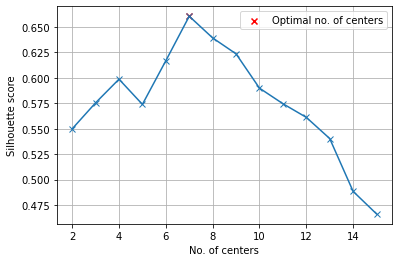

In [7]:
n_centers = np.arange(2, 16, 1)

centers = []
labels = []
silhouette_score = []
inertia = []

#Loop through different number of centers
for nc in n_centers:

    k_means_local = k_means(nc, 
                            'random', 
                            n_init = 50, 
                            max_iter = 100, 
                            verbose = True,
                            vectorise = True).fit(x, calculate_scores = True)
    
    centers.append(k_means_local.cluster_centers_)
    labels.append(k_means_local.predict(x))
    silhouette_score.append(k_means_local.silhouette_score)
    inertia.append(k_means_local.inertia_train_)

#Find optimal number of centers
pos_optimal = np.argmax(silhouette_score)
optimal_centers_kmeans = n_centers[pos_optimal]

#plotting
plt.figure()
plt.plot(n_centers, silhouette_score, marker = "x")
plt.xlabel("No. of centers")
plt.ylabel("Silhouette score")
plt.scatter(optimal_centers_kmeans, silhouette_score[pos_optimal], color = "r", marker = "x", label = "Optimal no. of centers")
plt.legend()
plt.grid()
plt.show()

### Visualise optimisation results and train best model

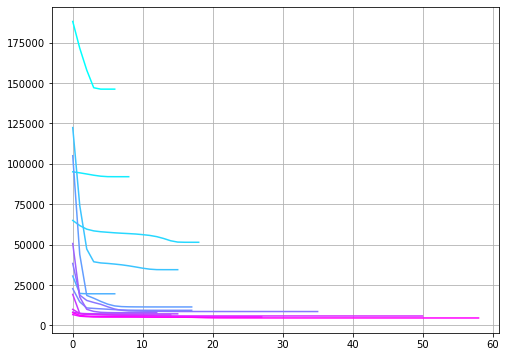

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 66403.45867197638
Outer iteration 0: inertia: 26893.583589973496
Outer iteration 0: inertia: 25683.392462700467
Outer iteration 0: inertia: 24871.568801005968
Outer iteration 0: inertia: 24493.437885352116
Outer iteration 0: inertia: 24372.741436964025
Outer iteration 0: inertia: 24325.254996522584
Outer iteration 0: inertia: 24303.655200065696
Outer iteration 0: inertia: 24293.58011286844
Outer iteration 0: inertia: 24291.224456879998
Outer iteration 0: inertia: 24290.46412224211
Outer iteration 0: inertia: 24290.073183309712
Outer iteration 0: inertia: 24289.851016725363
Outer iteration 0: inertia: 24289.723578108
Outer iteration 0: inertia: 24289.723578108

 Beginning outer iteration 1...
Outer iteration 1: inertia: 46694.0183197603
Outer iteration 1: inertia: 35207.46822450005
Outer iteration 1: inertia: 32529.85741799654
Outer iteration 1: inertia: 27964.70292787108
Outer iteration 1: inertia: 17816.


 Beginning outer iteration 12...
Outer iteration 12: inertia: 51525.51359082787
Outer iteration 12: inertia: 43339.79417313584
Outer iteration 12: inertia: 36608.84155125317
Outer iteration 12: inertia: 35852.32342687852
Outer iteration 12: inertia: 35823.056558645
Outer iteration 12: inertia: 35817.538226823744
Outer iteration 12: inertia: 35816.362041426764
Outer iteration 12: inertia: 35816.137832885535
Outer iteration 12: inertia: 35816.12448009252
Outer iteration 12: inertia: 35816.01976887641
Outer iteration 12: inertia: 35815.98735307977
Outer iteration 12: inertia: 35815.96456855754
Outer iteration 12: inertia: 35815.96456855754

 Beginning outer iteration 13...
Outer iteration 13: inertia: 29844.071795735
Outer iteration 13: inertia: 26495.296634317834
Outer iteration 13: inertia: 25236.063225082362
Outer iteration 13: inertia: 24557.92044982002
Outer iteration 13: inertia: 24331.148452237714
Outer iteration 13: inertia: 24304.94846430875
Outer iteration 13: inertia: 24300.10

Outer iteration 24: inertia: 29222.512532086566
Outer iteration 24: inertia: 28659.572431440236
Outer iteration 24: inertia: 28163.73571466235
Outer iteration 24: inertia: 27689.16001626753
Outer iteration 24: inertia: 27186.458773446397
Outer iteration 24: inertia: 26510.647896862218
Outer iteration 24: inertia: 25725.8524312855
Outer iteration 24: inertia: 25031.82169296139
Outer iteration 24: inertia: 24503.07904652204
Outer iteration 24: inertia: 24311.439725390333
Outer iteration 24: inertia: 24291.6846532574
Outer iteration 24: inertia: 24290.5249753262
Outer iteration 24: inertia: 24290.442054533352
Outer iteration 24: inertia: 24290.388978099498
Outer iteration 24: inertia: 24290.22979764057
Outer iteration 24: inertia: 24290.12826107987
Outer iteration 24: inertia: 24289.851746335982
Outer iteration 24: inertia: 24289.740426346216
Outer iteration 24: inertia: 24289.64334290257
Outer iteration 24: inertia: 24289.602480301983
Outer iteration 24: inertia: 24289.57498122615
Outer 

Outer iteration 35: inertia: 25700.538091206465
Outer iteration 35: inertia: 25700.356594075107
Outer iteration 35: inertia: 25700.119737462166
Outer iteration 35: inertia: 25699.809525754303
Outer iteration 35: inertia: 25699.373222287824
Outer iteration 35: inertia: 25699.073698786455
Outer iteration 35: inertia: 25698.73957590061
Outer iteration 35: inertia: 25698.450311462737
Outer iteration 35: inertia: 25698.189917463027
Outer iteration 35: inertia: 25697.89523653433
Outer iteration 35: inertia: 25697.836225675117
Outer iteration 35: inertia: 25697.836225675117

 Beginning outer iteration 36...
Outer iteration 36: inertia: 44524.75267235795
Outer iteration 36: inertia: 29300.922286586712
Outer iteration 36: inertia: 28477.204124157975
Outer iteration 36: inertia: 27886.59085711216
Outer iteration 36: inertia: 27366.385477705328
Outer iteration 36: inertia: 26749.44931436443
Outer iteration 36: inertia: 26033.396914566107
Outer iteration 36: inertia: 25276.016133370118
Outer itera

Outer iteration 47: inertia: 24343.04076308778
Outer iteration 47: inertia: 24312.543911819776
Outer iteration 47: inertia: 24299.975136691184
Outer iteration 47: inertia: 24294.081497163017
Outer iteration 47: inertia: 24291.275544301334
Outer iteration 47: inertia: 24289.998071748625
Outer iteration 47: inertia: 24289.44634957662
Outer iteration 47: inertia: 24289.42493999463
Outer iteration 47: inertia: 24289.42493999463

 Beginning outer iteration 48...
Outer iteration 48: inertia: 71871.2323151981
Outer iteration 48: inertia: 32362.18210925361
Outer iteration 48: inertia: 29731.31445990349
Outer iteration 48: inertia: 28996.528773057456
Outer iteration 48: inertia: 28457.203391949744
Outer iteration 48: inertia: 27739.270534707448
Outer iteration 48: inertia: 26985.349540493313
Outer iteration 48: inertia: 26314.33976171362
Outer iteration 48: inertia: 25849.26049647648
Outer iteration 48: inertia: 25715.59088762727
Outer iteration 48: inertia: 25702.680858745996
Outer iteration 4

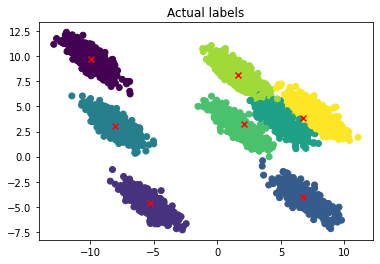

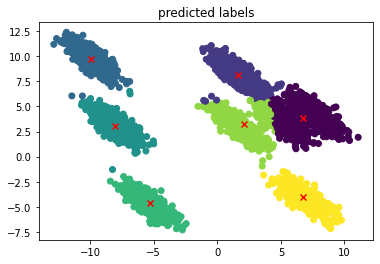

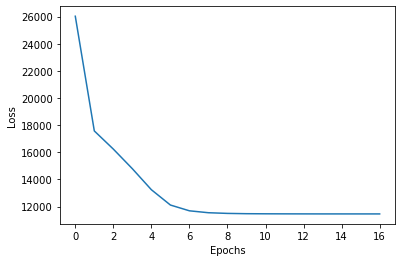

In [8]:
colors = plt.cm.cool(np.linspace(0, 1, len(n_centers)))

plt.figure(figsize = (8, 6))
for cnt, i in enumerate(n_centers):
    plt.plot(inertia[cnt], color = colors[cnt], label = str(i))
plt.grid()
plt.show()

#Fit the optimal model
k_means_optimal = k_means(optimal_centers_kmeans, 'random', 
                          n_init = 50, 
                          max_iter = 100, 
                          verbose = True).fit(x, calculate_scores = False)

labels_kmeans = k_means_optimal.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.plot(k_means_optimal.inertia_train_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### K-means run - Sklearn implementation

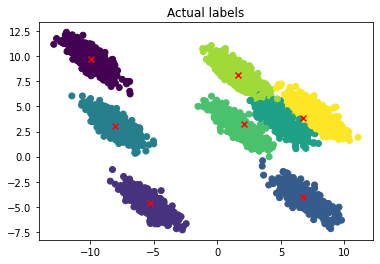

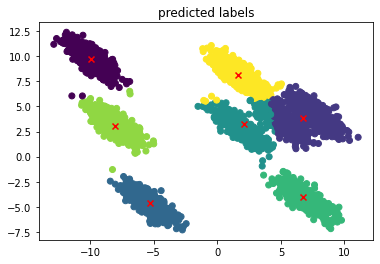

In [9]:
k_means_local = k_means_sklearn(optimal_centers_kmeans,
                                n_init = 50,
                                max_iter = 100)
k_means_local.fit(x)

labels_kmeans = k_means_local.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

## GMM run

In [10]:
n_centers = np.arange(2, 16, 1)
covariance_type = "full"
training_loss = []
labels = []
silhouette_score = []
aic = []
bic = []

for nc in n_centers:
    test_gmm_run = gaussian_mixture_models(nc, 
                                           covariance_type = covariance_type, 
                                           random_state = 0, 
                                           verbose = True, 
                                           vectorise=True).fit(x, calculate_scores = True)
    
    labels_GMM = test_gmm_run.predict(x)
    
    training_loss.append(test_gmm_run.loss_train_)
    labels.append(labels_GMM)
    silhouette_score.append(test_gmm_run.silhouette_score)
    aic.append(test_gmm_run.aic_score)
    bic.append(test_gmm_run.bic_score)
    



Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 241808.78529994184
Outer iteration 0: inertia: 241714.47003886587
Outer iteration 0: inertia: 241711.80403193214
Outer iteration 0: inertia: 241711.5508717511
Outer iteration 0: inertia: 241711.5508717511

 Beginning outer iteration 1...
Outer iteration 1: inertia: 220487.9373385908
Outer iteration 1: inertia: 171288.2377011927
Outer iteration 1: inertia: 166333.0080857655
Outer iteration 1: inertia: 161084.71713454844
Outer iteration 1: inertia: 149221.16476763727
Outer iteration 1: inertia: 146181.11969701143
Outer iteration 1: inertia: 146181.11969701143

 Beginning outer iteration 2...
Outer iteration 2: inertia: 278439.8843594077
Outer iteration 2: inertia: 242426.7005750729
Outer iteration 2: inertia: 193988.84426747344
Outer iteration 2: inertia: 173958.84196378343
Outer iteration 2: inertia: 160561.20332588255
Outer iter

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 99010.6986312556
Outer iteration 0: inertia: 98564.0036105869
Outer iteration 0: inertia: 98520.13709342123
Outer iteration 0: inertia: 98245.26192671685
Outer iteration 0: inertia: 96016.07147695661
Outer iteration 0: inertia: 90835.56342227975
Outer iteration 0: inertia: 89806.20874736956
Outer iteration 0: inertia: 89568.61309940882
Outer iteration 0: inertia: 89313.50667744021
Outer iteration 0: inertia: 89038.14567514417
Outer iteration 0: inertia: 88800.58117061545
Outer iteration 0: inertia: 88623.79569596057
Outer iteration 0: inertia: 88509.34479527688
Outer iteration 0: inertia: 88456.52910268781
Outer iteration 0: inertia: 88435.92748881404
Outer iteration 0: inertia: 88429.2613217788
Outer iteration 0: inertia: 88424.38631336161
Outer iteration 0: inertia: 88420.5404316548
Outer 

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 36132.31687542402
Outer iteration 0: inertia: 34978.57350315357
Outer iteration 0: inertia: 34596.04962454006
Outer iteration 0: inertia: 34522.38759604095
Outer iteration 0: inertia: 34511.81256379229
Outer iteration 0: inertia: 34510.29141183573
Outer iteration 0: inertia: 34510.27709280668
Outer iteration 0: inertia: 34510.1853049208
Outer iteration 0: inertia: 34510.1853049208

 Beginning outer iteration 1...
Outer iteration 1: inertia: 85560.3459265
Outer iteration 1: inertia: 49646.18923840474
Outer iteration 1: inertia: 42469.670974703
Outer iteration 1: inertia: 42125.25428333434
Outer iteration 1: inertia: 41895.019711159606
Outer iteration 1: inertia: 41636.40162606227
Outer iteration 1: inertia: 41238.67720248774
Outer iteration 1: inertia: 40751.62570903611
Outer iteration 1: ine

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 91540.29125226561
Outer iteration 0: inertia: 83408.02758301752
Outer iteration 0: inertia: 81283.19362995386
Outer iteration 0: inertia: 79922.20152045813
Outer iteration 0: inertia: 79282.64301994239
Outer iteration 0: inertia: 78805.73299396678
Outer iteration 0: inertia: 78440.36023830452
Outer iteration 0: inertia: 78297.07927357781
Outer iteration 0: inertia: 78239.5031183043
Outer iteration 0: inertia: 78218.09603167007
Outer iteration 0: inertia: 78205.87465404191
Outer iteration 0: inertia: 78199.38860010405
Outer iteration 0: inertia: 78197.60139079943
Outer iteration 0: inertia: 78197.32127712328
Outer iteration 0: inertia: 78197.19799237984
Outer iteration 0: inertia: 78197.19799237984

 Beginning outer iteration 1...
Outer iteration 1: inertia: 30769.702495534577
Outer iteration

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 59040.51499079038
Outer iteration 0: inertia: 43131.88605896169
Outer iteration 0: inertia: 36407.10593046508
Outer iteration 0: inertia: 33612.66233258326
Outer iteration 0: inertia: 32134.498061909242
Outer iteration 0: inertia: 29834.234888793035
Outer iteration 0: inertia: 25492.381763764806
Outer iteration 0: inertia: 21129.935870427074
Outer iteration 0: inertia: 20389.769992359128
Outer iteration 0: inertia: 20157.80093306911
Outer iteration 0: inertia: 19913.798092694666
Outer iteration 0: inertia: 19618.85868639521
Outer iteration 0: inertia: 19350.59366826843
Outer iteration 0: inertia: 19144.726949469336
Outer iteration 0: inertia: 19014.25504811169
Outer iteration 0: inertia: 18947.826608534568
Outer iteration 0: inertia: 18913.01710498843
Outer iteration 0: inertia: 18901.818137


Loss at epoch 7: -22254.030142489082
Tolerance: 0.0021341804022085853

Loss at epoch 8: -22254.029641907735
Tolerance: 0.0005005813472962473

Finished GMM training!
Time to train: 0.3930 seconds
Calculating Silhouette score...
Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 32267.668711247643
Outer iteration 0: inertia: 20615.826685603253
Outer iteration 0: inertia: 18465.916470410346
Outer iteration 0: inertia: 18358.702849629277
Outer iteration 0: inertia: 18327.70634604271
Outer iteration 0: inertia: 18320.260525888916
Outer iteration 0: inertia: 18317.411459171108
Outer iteration 0: inertia: 18316.83603703739
Outer iteration 0: inertia: 18316.77996649754
Outer iteration 0: inertia: 18316.77996649754

 Beginning outer iteration 1...
Outer iteration 1: inertia: 42645.22338782936
Outer iteration 1: inertia: 25927.171892421073
Outer iter

Outer iteration 9: inertia: 23556.389271940847
Outer iteration 9: inertia: 23544.259123605752
Outer iteration 9: inertia: 23535.348601581547
Outer iteration 9: inertia: 23526.483352875788
Outer iteration 9: inertia: 23522.027092250093
Outer iteration 9: inertia: 23520.887559153583
Outer iteration 9: inertia: 23520.44104531668
Outer iteration 9: inertia: 23520.02123967532
Outer iteration 9: inertia: 23519.85644278503
Outer iteration 9: inertia: 23519.826181445867
Outer iteration 9: inertia: 23519.66064107011
Outer iteration 9: inertia: 23519.66064107011

 Finished Training! Automatically selecting optimal centers...

Finished k-means
Running GMM...

Loss at epoch 0: -21963.618484812785
Tolerance: 169.8555034060155

Loss at epoch 1: -21882.797156073262
Tolerance: 80.82132873952287

Loss at epoch 2: -21870.638954541762
Tolerance: 12.158201531499799

Loss at epoch 3: -21869.553305509056
Tolerance: 1.0856490327059873

Loss at epoch 4: -21869.35025728596
Tolerance: 0.20304822309481096

Loss 

Outer iteration 7: inertia: 22491.695401338755
Outer iteration 7: inertia: 21757.79517610046
Outer iteration 7: inertia: 18280.154512921534
Outer iteration 7: inertia: 10700.735383303414
Outer iteration 7: inertia: 8698.562712208311
Outer iteration 7: inertia: 8657.741598129121
Outer iteration 7: inertia: 8657.658144883762
Outer iteration 7: inertia: 8657.533091990605
Outer iteration 7: inertia: 8657.502495490717
Outer iteration 7: inertia: 8657.502495490717

 Beginning outer iteration 8...
Outer iteration 8: inertia: 53722.960417146605
Outer iteration 8: inertia: 26781.5630249757
Outer iteration 8: inertia: 24618.0200717797
Outer iteration 8: inertia: 23747.66024234081
Outer iteration 8: inertia: 23506.76970808177
Outer iteration 8: inertia: 23383.64401372171
Outer iteration 8: inertia: 23321.7832104753
Outer iteration 8: inertia: 23283.8875404036
Outer iteration 8: inertia: 23253.1563264581
Outer iteration 8: inertia: 23221.931486349844
Outer iteration 8: inertia: 23174.741550386556


Outer iteration 4: inertia: 7998.623955279815
Outer iteration 4: inertia: 7998.623955279815

 Beginning outer iteration 5...
Outer iteration 5: inertia: 14751.151251081073
Outer iteration 5: inertia: 9456.092952732564
Outer iteration 5: inertia: 9254.354310523951
Outer iteration 5: inertia: 8950.562743551149
Outer iteration 5: inertia: 8239.90384528701
Outer iteration 5: inertia: 8009.2509132516825
Outer iteration 5: inertia: 7975.7207544927405
Outer iteration 5: inertia: 7970.263364155766
Outer iteration 5: inertia: 7969.019579000174
Outer iteration 5: inertia: 7968.56083370395
Outer iteration 5: inertia: 7967.961624319176
Outer iteration 5: inertia: 7967.661720680349
Outer iteration 5: inertia: 7967.358592613971
Outer iteration 5: inertia: 7967.210339036728
Outer iteration 5: inertia: 7967.15092169928
Outer iteration 5: inertia: 7967.123272056544
Outer iteration 5: inertia: 7966.968901811633
Outer iteration 5: inertia: 7966.732045198696
Outer iteration 5: inertia: 7966.587038347239
O


Loss at epoch 23: -21864.75431406851
Tolerance: 0.04739408391469624

Loss at epoch 24: -21864.708604006213
Tolerance: 0.04571006229525665

Loss at epoch 25: -21864.66464503821
Tolerance: 0.043958968002698384

Loss at epoch 26: -21864.622528488857
Tolerance: 0.042116549353522714

Loss at epoch 27: -21864.582353473343
Tolerance: 0.040175015514250845

Loss at epoch 28: -21864.544213944122
Tolerance: 0.03813952922064345

Loss at epoch 29: -21864.50818904028
Tolerance: 0.036024903842189815

Loss at epoch 30: -21864.474336503146
Tolerance: 0.03385253713349812

Loss at epoch 31: -21864.44268883509
Tolerance: 0.03164766805639374

Loss at epoch 32: -21864.413251798764
Tolerance: 0.029437036326271482

Loss at epoch 33: -21864.386004808963
Tolerance: 0.02724698980091489

Loss at epoch 34: -21864.360902762866
Tolerance: 0.025102046096435515

Loss at epoch 35: -21864.337878879203
Tolerance: 0.023023883662972366

Loss at epoch 36: -21864.316848162707
Tolerance: 0.0210307164961705

Loss at epoch 37:

Outer iteration 7: inertia: 9532.911521647855
Outer iteration 7: inertia: 9346.523682515031
Outer iteration 7: inertia: 9271.584667942936
Outer iteration 7: inertia: 9227.388500847586
Outer iteration 7: inertia: 9201.167132692159
Outer iteration 7: inertia: 9181.603359703884
Outer iteration 7: inertia: 9161.926379956083
Outer iteration 7: inertia: 9134.279859569493
Outer iteration 7: inertia: 9100.112019049377
Outer iteration 7: inertia: 9053.887267715178
Outer iteration 7: inertia: 8995.660384450972
Outer iteration 7: inertia: 8902.373389732928
Outer iteration 7: inertia: 8732.504252126075
Outer iteration 7: inertia: 8497.217359966868
Outer iteration 7: inertia: 8268.685328349155
Outer iteration 7: inertia: 8104.856061558895
Outer iteration 7: inertia: 8002.115366136939
Outer iteration 7: inertia: 7957.740716729184
Outer iteration 7: inertia: 7945.2481523703045
Outer iteration 7: inertia: 7942.604702979364
Outer iteration 7: inertia: 7941.780104630178
Outer iteration 7: inertia: 7941.


Loss at epoch 71: -21863.451453513237
Tolerance: 0.0031684007408330217

Loss at epoch 72: -21863.44827952535
Tolerance: 0.0031739878868393134

Loss at epoch 73: -21863.44509867886
Tolerance: 0.0031808464882487897

Loss at epoch 74: -21863.441909802135
Tolerance: 0.0031888767261989415

Loss at epoch 75: -21863.438711812752
Tolerance: 0.0031979893828975037

Loss at epoch 76: -21863.43550370803
Tolerance: 0.0032081047211249825

Loss at epoch 77: -21863.43228455658
Tolerance: 0.003219151451048674

Loss at epoch 78: -21863.42905349075
Tolerance: 0.0032310658316418994

Loss at epoch 79: -21863.42580969988
Tolerance: 0.0032437908703286666

Loss at epoch 80: -21863.422552424243
Tolerance: 0.0032572756354056764

Loss at epoch 81: -21863.41928094966
Tolerance: 0.003271474583016243

Loss at epoch 82: -21863.415994602627
Tolerance: 0.003286347033281345

Loss at epoch 83: -21863.412692746006
Tolerance: 0.003301856620964827

Loss at epoch 84: -21863.409374775125
Tolerance: 0.0033179708807438146

Lo

Outer iteration 5: inertia: 7264.146226363463

 Beginning outer iteration 6...
Outer iteration 6: inertia: 15719.407549587642
Outer iteration 6: inertia: 8246.976144749398
Outer iteration 6: inertia: 7872.758520663543
Outer iteration 6: inertia: 7803.695937162526
Outer iteration 6: inertia: 7771.00096823121
Outer iteration 6: inertia: 7748.0003701000305
Outer iteration 6: inertia: 7730.425912971635
Outer iteration 6: inertia: 7715.112923179288
Outer iteration 6: inertia: 7702.854504284058
Outer iteration 6: inertia: 7692.52772888722
Outer iteration 6: inertia: 7688.455961939604
Outer iteration 6: inertia: 7684.397612104827
Outer iteration 6: inertia: 7680.294864049045
Outer iteration 6: inertia: 7678.151134180262
Outer iteration 6: inertia: 7677.167314429687
Outer iteration 6: inertia: 7676.940072434439
Outer iteration 6: inertia: 7676.867281007403
Outer iteration 6: inertia: 7676.558965291476
Outer iteration 6: inertia: 7676.362045445049
Outer iteration 6: inertia: 7676.096041431799
O


Loss at epoch 33: -21863.016599325776
Tolerance: 0.02596757488208823

Loss at epoch 34: -21862.992468833203
Tolerance: 0.02413049257302191

Loss at epoch 35: -21862.96997730805
Tolerance: 0.022491525152872782

Loss at epoch 36: -21862.94894814521
Tolerance: 0.02102916283911327

Loss at epoch 37: -21862.929223947165
Tolerance: 0.01972419804587844

Loss at epoch 38: -21862.910664488827
Tolerance: 0.018559458338131662

Loss at epoch 39: -21862.89314490591
Tolerance: 0.01751958291788469

Loss at epoch 40: -21862.87655407445
Tolerance: 0.016590831459325273

Loss at epoch 41: -21862.86079315698
Tolerance: 0.0157609174711979

Loss at epoch 42: -21862.845774296104
Tolerance: 0.015018860874988604

Loss at epoch 43: -21862.831419440052
Tolerance: 0.01435485605179565

Loss at epoch 44: -21862.81765928688
Tolerance: 0.013760153171460843

Loss at epoch 45: -21862.804432336154
Tolerance: 0.013226950726675568

Loss at epoch 46: -21862.791684037933
Tolerance: 0.012748298220685683

Loss at epoch 47: -

Outer iteration 5: inertia: 5874.026667142585
Outer iteration 5: inertia: 5873.739247540969
Outer iteration 5: inertia: 5873.5895581638215
Outer iteration 5: inertia: 5873.378107156763
Outer iteration 5: inertia: 5872.470257600293
Outer iteration 5: inertia: 5870.551565471886
Outer iteration 5: inertia: 5869.759333903283
Outer iteration 5: inertia: 5869.344095947645
Outer iteration 5: inertia: 5868.9371016955265
Outer iteration 5: inertia: 5867.984404586909
Outer iteration 5: inertia: 5866.589022725464
Outer iteration 5: inertia: 5863.627381385915
Outer iteration 5: inertia: 5861.329547902242
Outer iteration 5: inertia: 5859.828786059403
Outer iteration 5: inertia: 5858.943076672111
Outer iteration 5: inertia: 5858.368375725622
Outer iteration 5: inertia: 5857.190626675461
Outer iteration 5: inertia: 5856.505532655981
Outer iteration 5: inertia: 5856.056951008884
Outer iteration 5: inertia: 5855.608406806703
Outer iteration 5: inertia: 5855.508455997588
Outer iteration 5: inertia: 5855


Loss at epoch 29: -21857.904705888497
Tolerance: 0.1005571774658165

Loss at epoch 30: -21857.809964001113
Tolerance: 0.09474188738386147

Loss at epoch 31: -21857.720638403825
Tolerance: 0.08932559728782508

Loss at epoch 32: -21857.636373967085
Tolerance: 0.0842644367403409

Loss at epoch 33: -21857.55685177129
Tolerance: 0.0795221957960166

Loss at epoch 34: -21857.48178301035
Tolerance: 0.07506876093975734

Loss at epoch 35: -21857.410904064833
Tolerance: 0.07087894551659701

Loss at epoch 36: -21857.343972451014
Tolerance: 0.06693161381917889

Loss at epoch 37: -21857.2807634377
Tolerance: 0.06320901331491768

Loss at epoch 38: -21857.221067194354
Tolerance: 0.059696243344660616

Loss at epoch 39: -21857.164686388795
Tolerance: 0.05638080555945635

Loss at epoch 40: -21857.111434190418
Tolerance: 0.053252198376867454

Loss at epoch 41: -21857.061132655865
Tolerance: 0.05030153455300024

Loss at epoch 42: -21857.013611480135
Tolerance: 0.04752117572934367

Loss at epoch 43: -21856

Outer iteration 5: inertia: 6256.283668310982
Outer iteration 5: inertia: 6256.2209002354
Outer iteration 5: inertia: 6256.183637426395
Outer iteration 5: inertia: 6256.095659036936
Outer iteration 5: inertia: 6256.042345743331
Outer iteration 5: inertia: 6256.003993342915
Outer iteration 5: inertia: 6255.927665892795
Outer iteration 5: inertia: 6255.901906992551
Outer iteration 5: inertia: 6255.901906992551

 Beginning outer iteration 6...
Outer iteration 6: inertia: 9358.251799544132
Outer iteration 6: inertia: 7648.3820374537645
Outer iteration 6: inertia: 6655.986362401093
Outer iteration 6: inertia: 6082.043157528735
Outer iteration 6: inertia: 5857.510590177428
Outer iteration 6: inertia: 5734.0224029634055
Outer iteration 6: inertia: 5685.933000281565
Outer iteration 6: inertia: 5676.067675784553
Outer iteration 6: inertia: 5670.517924382082
Outer iteration 6: inertia: 5666.405593882182
Outer iteration 6: inertia: 5657.250708943991
Outer iteration 6: inertia: 5630.615046909694
O

C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Outer iteration 9: inertia: 7341.6398100309925
Outer iteration 9: inertia: 6386.27168235962
Outer iteration 9: inertia: 6376.092358435208
Outer iteration 9: inertia: 6369.320069184047
Outer iteration 9: inertia: 6365.61593864142
Outer iteration 9: inertia: 6363.781588697796
Outer iteration 9: inertia: 6362.888946305537
Outer iteration 9: inertia: 6362.388948120974
Outer iteration 9: inertia: 6362.3121915902075
Outer iteration 9: inertia: 6362.284709786362
Outer iteration 9: inertia: 6362.230122087058
Outer iteration 9: inertia: 6362.201019923544
Outer iteration 9: inertia: 6362.201019923544

 Finished Training! Automatically selecting optimal centers...

Finished k-means
Running GMM...

Loss at epoch 0: -21986.748730270476
Tolerance: 155.2646823149007

Loss at epoch 1: -21931.086371350044
Tolerance: 55.66235892043187

Loss at epoch 2: -21899.42803849675
Tolerance: 31.65833285329427

Loss at epoch 3: -21882.191036090964
Tolerance: 17.23700240578546

Loss at epoch 4: -21873.675750954506


Outer iteration 3: inertia: 5700.437535208326
Outer iteration 3: inertia: 5696.230261942208
Outer iteration 3: inertia: 5694.370087525624
Outer iteration 3: inertia: 5693.525650047902
Outer iteration 3: inertia: 5693.121593444688
Outer iteration 3: inertia: 5692.89300960982
Outer iteration 3: inertia: 5692.855604123144
Outer iteration 3: inertia: 5692.754109372679
Outer iteration 3: inertia: 5692.728869721238
Outer iteration 3: inertia: 5692.728869721238

 Beginning outer iteration 4...
Outer iteration 4: inertia: 10414.33757986459
Outer iteration 4: inertia: 6499.2348926324385
Outer iteration 4: inertia: 6050.329639383829
Outer iteration 4: inertia: 5929.529240784751
Outer iteration 4: inertia: 5885.363621847893
Outer iteration 4: inertia: 5862.300121162931
Outer iteration 4: inertia: 5849.063073367922
Outer iteration 4: inertia: 5844.083758764635
Outer iteration 4: inertia: 5842.097440711676
Outer iteration 4: inertia: 5841.014474471659
Outer iteration 4: inertia: 5840.108844715038
O


Loss at epoch 18: -21857.134240282037
Tolerance: 0.14574306951544713

Loss at epoch 19: -21857.00224885055
Tolerance: 0.13199143148813164

Loss at epoch 20: -21856.881635246198
Tolerance: 0.12061360435109236

Loss at epoch 21: -21856.77059229704
Tolerance: 0.11104294915639912

Loss at epoch 22: -21856.66774308645
Tolerance: 0.102849210590648

Loss at epoch 23: -21856.57203853057
Tolerance: 0.09570455588254845

Loss at epoch 24: -21856.482678763958
Tolerance: 0.08935976661086897

Loss at epoch 25: -21856.39905174588
Tolerance: 0.08362701807709527

Loss at epoch 26: -21856.32068482415
Tolerance: 0.07836692173077608

Loss at epoch 27: -21856.24720646728
Tolerance: 0.07347835686960025

Loss at epoch 28: -21856.178316266974
Tolerance: 0.06889020030575921

Loss at epoch 29: -21856.11376181911
Tolerance: 0.06455444786479347

Loss at epoch 30: -21856.05332136472
Tolerance: 0.06044045438829926

Loss at epoch 31: -21855.996791221987
Tolerance: 0.05653014273411827

Loss at epoch 32: -21855.94397

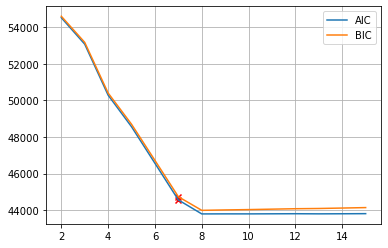

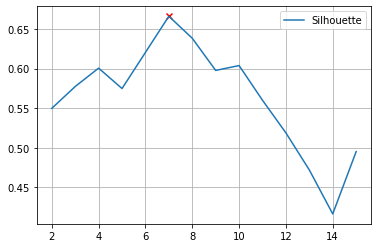

7


In [11]:
#Find optimal number of centers
pos_optimal = np.argmax(silhouette_score)
optimal_centers_GMM = n_centers[pos_optimal]    

plt.figure()
plt.plot(n_centers, aic, label = "AIC")
plt.plot(n_centers, bic, label = "BIC")
plt.scatter(optimal_centers_GMM, aic[pos_optimal], color = "r", marker = "x")
plt.scatter(optimal_centers_GMM, bic[pos_optimal], color = "r", marker = "x")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(n_centers, silhouette_score, label = "Silhouette")
plt.scatter(optimal_centers_GMM, silhouette_score[pos_optimal], color = "r", marker = "x")
plt.legend()
plt.grid()
plt.show()

nc_GMM = optimal_centers_GMM

print(nc_GMM)

### Visualise optimisation results and train best model


Finished k-means
Finished in: 0.235 seconds


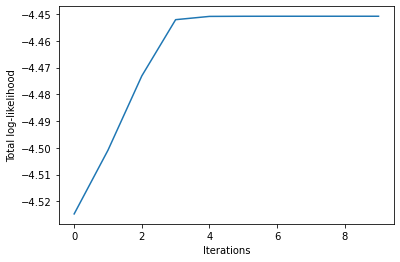

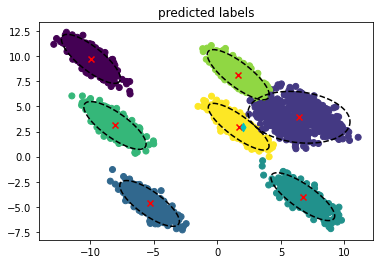

In [12]:
#Visualise all 
t0 = time.time()
optimal_model = gaussian_mixture_models(nc_GMM, 
                                        covariance_type = covariance_type, 
                                        use_sklearn = True,
                                        random_state = 0, 
                                        verbose = False, 
                                        vectorise = True).fit(x, False)

print("Finished in: {:.3f} seconds".format(time.time() - t0))

labels_GMM = optimal_model.predict(x)
weights_GMM, means_GMM, covariances_GMM = optimal_model.get_params()


plt.figure()
plt.plot(np.array(optimal_model.loss_train_) / x.shape[0])
plt.ylabel("Total log-likelihood")
plt.xlabel("Iterations")
plt.show()

query = np.array([[2, 3]])

resp = optimal_model.posterior_likelihood(query.T)

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_GMM)
plt.scatter(means_GMM[:, 0], means_GMM[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")


for k in range(nc_GMM):
    ellipse = plot_ellipse(means_GMM[k, :], covariances_GMM[k, :, :], X2_critical = 5.991)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")

    
plt.show()

### Visualise NLL on data space

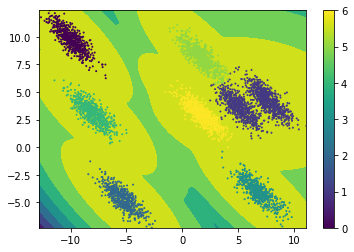

In [13]:
X, Y = np.meshgrid(np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100), np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100))

XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
Z = []

p_x, ll, ll_sum = optimal_model.data_likelihood(XY)

plt.figure()
plt.contourf(X, Y, ll_sum.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = labels_GMM, s = 1)
plt.colorbar()
plt.show()

### Compare to Scikit learn version

Finished in: 0.061 seconds


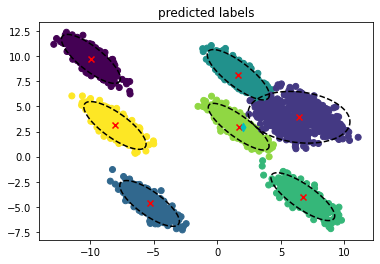

In [14]:
from sklearn.mixture import GaussianMixture

t0 = time.time()
gm = GaussianMixture(n_components=nc_GMM, random_state=0, covariance_type = covariance_type).fit(x)
print("Finished in: {:.3f} seconds".format(time.time() - t0))

gm_labels = gm.predict(x)

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = gm_labels)
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")

for k in range(nc_GMM):
    ellipse = plot_ellipse(gm.means_[k, :], gm.covariances_[k, :, :], X2_critical = 5.991, pca_method = False)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")

    
plt.show()

### Compare results:

In [15]:
print(gm.lower_bound_, optimal_model.lower_bound_)

print(gm.weights_, "\n")
print(optimal_model.weights_, "\n")

print(gm.means_, "\n")
print(optimal_model.means_, "\n")

print(gm.covariances_, "\n")
print(optimal_model.covariances_, "\n")

-4.4508290494345655 -4.450805920229603
[0.1264     0.26116843 0.1148     0.12248209 0.12154785 0.12800163
 0.1256    ] 

[0.1264     0.26150074 0.1148     0.12154828 0.1256     0.12228772
 0.12786326] 

[[-9.93678311  9.75010561]
 [ 6.42656381  3.92429699]
 [-5.32462835 -4.67215098]
 [ 1.6505337   8.16877389]
 [ 6.72368568 -3.99683388]
 [ 1.68052722  2.9838976 ]
 [-8.04638468  3.1081518 ]] 

[[-9.93678311  9.75010561]
 [ 6.42236432  3.92509671]
 [-5.32462835 -4.67215098]
 [ 6.72367464 -3.99682125]
 [-8.04638468  3.1081518 ]
 [ 1.64750084  8.172686  ]
 [ 1.67962969  2.9839693 ]] 

[[[ 0.8975466  -0.7566586 ]
  [-0.7566586   0.99739124]]

 [[ 2.67262977 -0.30439202]
  [-0.30439202  1.11153902]]

 [[ 0.91424005 -0.69305028]
  [-0.69305028  0.87086216]]

 [[ 0.9978172  -0.82423875]
  [-0.82423875  1.05357469]]

 [[ 1.05007994 -0.8029832 ]
  [-0.8029832   0.95130936]]

 [[ 0.95323341 -0.76926296]
  [-0.76926296  0.90713295]]

 [[ 1.00047024 -0.75787627]
  [-0.75787627  0.94772214]]] 

[[[ 0